In [1]:
import pandas as pd
import seaborn as sns
import pandas as pd
import glob, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, mannwhitneyu
from dna_features_translator_class import coverage_graph
from importlib import reload
import make_junctions
from statannot import add_stat_annotation
import utils
import dna_features_translator_class as dftc
import flanking_regions as fr
from consts import PH_COLORS

reload(dftc)
reload(fr)
reload(make_junctions)
reload(utils)
plt.style.use('default')
final = pd.read_csv('final.csv')
from ast import literal_eval
final.Gene_order = final.Gene_order.dropna().apply(literal_eval)
final.organism = final.organism.str.replace(' ', '_')
final = final[['organism', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'Gene_order']]

display(final.head(3))

,organism,kingdom,phylum,class,order,family,genus,Gene_order
0,Acropora_aculeus,Metazoa,Cnidaria,Anthozoa,Scleractinia,Acroporidae,Acropora,"[nad1, cob, nad2, nad6, atp6, nad4, rrnS, cox3..."
1,Acropora_aspera,Metazoa,Cnidaria,Anthozoa,Scleractinia,Acroporidae,Acropora,"[nad1, cob, nad2, nad6, atp6, nad4, rrnS, cox3..."
2,Acropora_digitifera,Metazoa,Cnidaria,Anthozoa,Scleractinia,Acroporidae,Acropora,"[nad1, cob, nad2, nad6, atp6, nad4, rrnS, cox3..."


In [5]:
##############################
# Dataset creation block
##############################
path = r'data' # use your path
all_files = glob.glob(os.path.join('data', 'junctions', "*.csv")) # Glob all files within data/junctions
min_org_count = 5 # threshold of samples below-which organisms are filtered from the final dataset
remove_orgs = ['Hypsibius_dujardini'] # list of organisms to be removed from the final dataset

expre = []
li = []
orgs = {}
c=0
for filename in all_files: # iterate through all files in the folder

    #import the current junction csv
    df = pd.read_csv(filename, index_col=0, header=0)
    try:
        if df.junc_counts.sum() == 0: continue # skip empty files
    except AttributeError: continue
    org_name = df['_org'].iloc[0] # get the organism name from the file name
    if org_name in orgs.keys(): # if the organism is already in the dictionary, add the current file to the list of files for that organism
        orgs[org_name] += 1
    else: # if the organism is not in the dictionary, add it and add the current file to the list of files for that organism
        orgs[org_name] = 1
        
    #TPM mean and standard deviation of right and left genes
    left_mean = df._left_tpm.mean()
    left_std = df._left_tpm.std()
    left_max = df._left_tpm.max()
    left_min = df._left_tpm.min()
    
    right_mean = df._right_tpm.mean()
    right_std = df._right_tpm.std()
    right_max = df._right_tpm.max()
    right_min = df._right_tpm.min()
    
    
    #TPM and RPKM junction mean and std
    tpm_junc_mean = df.junc_tpm.mean()
    rpkm_junc_mean = df.junc_rpkm.mean()
    tpm_junc_std = df.junc_tpm.std()
    rpkm_junc_std = df.junc_rpkm.std()
    tpm_junc_max = df.junc_tpm.max()
    rpkm_junc_max = df.junc_rpkm.max()
    tpm_junc_min = df.junc_tpm.min()
    rpkm_junc_min = df.junc_rpkm.min()
    
    #Z score for junction TPM and RPKM
    df['junc_tpm_z'] = df.junc_tpm.apply(utils.z_score, args = [tpm_junc_mean, tpm_junc_std])
    df['junc_rpkm_z'] = df.junc_rpkm.apply(utils.z_score, args = [rpkm_junc_mean, rpkm_junc_std])

    #Z score for left and right genes - based on TPM
    df['left_z'] = df._left_tpm.apply(utils.z_score, args = [left_mean, left_std])
    df['right_z'] = df._right_tpm.apply(utils.z_score, args = [right_mean, right_std])
    
    # MinMax score for junction TPM and RPKM
    df['junc_tpm_mm'] = df.junc_tpm.apply(utils.scale_min_max, mini = tpm_junc_min, maxi = tpm_junc_max)
    df['junc_rpkm_mm'] = df.junc_tpm.apply(utils.scale_min_max, mini = rpkm_junc_min, maxi = rpkm_junc_max)
    
    # MinMax score for left and right genes - based on RPKM
    df['left_mm'] = df._left_rpkm.apply(utils.scale_min_max, mini = left_min, maxi = left_max)
    df['right_mm'] = df._right_rpkm.apply(utils.scale_min_max, mini = right_min, maxi = right_max)

    df['exp_diff'] = abs(df._left_tpm - df._right_tpm) # absolute difference in expression between left and right genes
    
    df['sample'] = os.path.basename(filename).replace('.csv','')
    
    #Append the current sample df to a df list
    li.append(df)
    c+=1
#Remove any organism with less than 5 samples.
new_li = []
for df in li:
    if orgs[df._org.iloc[0]] < min_org_count: # if the organism has less than 5 samples
        print(f'{df._org.iloc[0]} was removed from the database!') # print the organism name and skip it
        continue
    elif df._org.iloc[0] in remove_orgs: # if the organism is in the remove_orgs list skip it
        continue
    else:
        new_li.append(df)
display(f'Total amount of junction files: {c} split into {len(orgs)} organisms') # print the total amount of junction files and the amount of organisms
display(f'Sample count for each org') # print the amount of samples for each organism
[display(f'{k} : {v}') for k,v in orgs.items() if v >= min_org_count]

#Combine all sample junction dfs to a single one
frame = pd.concat(new_li, axis=0, ignore_index=True) # concatenate all sample dfs to a single one
cols = frame.columns.to_list() # get the columns of the frame

frame.columns = [i.replace('_','', 1) if i.startswith('_') else i for i in cols] # replace the underscore with a space
frame = frame.merge(final, how = 'left', left_on = 'org', right_on = 'organism') # merge the organism name with the final df

deseqs = []
for exp in frame['dataset'].unique(): # for each experiment
    temp = utils.deseq_from_long(frame.loc[frame['dataset'] == exp, :],'gpair', 'junc_counts','sample') # get the deseq df using the deseq normalization calculation function in utils.
    deseqs.append(temp) # append the deseq df to a list
    
deseq_df = pd.concat(deseqs, axis = 0, ignore_index = True) # concatenate all deseq dfs to a single one
frame = frame.merge(deseq_df, how = 'left', on = ['gpair', 'sample']) # merge the deseq df with the frame df


frame['left_tpm_raw'] = frame['left_tpm']
frame['right_tpm_raw'] = frame['right_tpm']
frame['left_rpkm_raw'] = frame['left_rpkm']
frame['right_rpkm_raw'] = frame['right_rpkm']
frame['junc_tpm_raw'] = frame['junc_tpm']
frame['junc_rpkm_raw'] = frame['junc_rpkm']

#Take the log value of these columns:
take_log = ['left_tpm', 'right_tpm', 'left_rpkm', 'right_rpkm', 'junc_tpm', 'junc_rpkm', 'mean_RPM', 'median_RPM', 'junc_deseq', 'exp_diff']
for i in take_log:
    frame[i] = np.log2(frame[i] + 1)


filtered = pd.DataFrame(columns = frame.columns)
for data in frame['dataset'].unique():
    cur_df = frame.loc[frame.dataset == data, :]
    # Remove datasets with an average junction count that is lower than 0
    cur_junc_mean = cur_df.junc_counts.mean()
    cur_junc_0_prop = np.mean(cur_df.junc_counts == 0) # proportion of junctions with 0 counts
    if (cur_junc_mean < 1) or (cur_junc_0_prop > .5): # if the average junction count is lower than 1 or the proportion of junctions with 0 counts is higher than 50%
        print(f'In dataset {data}\nThe junction counts mean is less than 1 : {cur_junc_mean}\n0 junc counts proportion : {cur_junc_0_prop}') # print the dataset name and the average junction count
        continue # skip the dataset
        
    cur_left_mean = cur_df.left_tpm.mean()
    cur_left_std = cur_df.left_tpm.std()
    cur_left_filter = cur_left_mean - cur_left_std*2 # filter the left tpm values
    cur_right_mean = cur_df.right_tpm.mean()
    cur_right_std = cur_df.right_tpm.std()
    cur_right_filter = cur_right_mean - cur_right_std*2 # get the mean and std of the left and right genes
    cur_df = cur_df.loc[(cur_df.left_tpm > cur_left_filter) & (cur_df.right_tpm > cur_right_filter), :] # filter the dataframe based on the left and right mean and std (2 std) of the tpm values of the left and right genes 
    
    filtered = filtered.append(cur_df)

#Create a list of deseq output dataframes to combine into the main df
filtered = filtered.drop(columns = ['Feature', 'ID'])
filtered = filtered.replace({'RNR1':'srRNA', 'RNR2':'lrRNA', 'rrnS':'srRNA', 'rrnL':'lrRNA', '16S rRNA' : 'lrRNA', '12S rRNA' : 'srRNA'},regex = True) # replace the rRNA names with the correct ones
filtered.strand_switch = filtered.strand_switch.astype(str)
filtered = filtered.loc[filtered.junc_tpm > 0, :]
filtered.loc[filtered.strand_switch == 'True', 'strand_switch'] = 'DSJ'
filtered.loc[filtered.strand_switch == 'False', 'strand_switch'] = 'SSJ'
#filtered['falloff'] = filtered.apply(falloff_score, axis = 1)
filtered['junc_type'] = filtered.apply(utils.junc_type, axis = 1)


display(len(frame))
display(len(filtered))
display(filtered.org.unique()) # print the unique organisms in the filtered df
filtered.to_csv('junctions_filtered_rerun.csv', index = False) # save the filtered df to a csv file
frame.to_csv('junctions_unfiltered_rerun.csv', index = False) # save the unfiltered dataframe to a csv file
 
del deseq_df, deseqs, temp, orgs, expre, li, all_files, frame, new_li # delete all the variables that are no longer needed

Macaca_mulatta was removed from the database!
Macaca_mulatta was removed from the database!
Portunus_trituberculatus was removed from the database!
Portunus_trituberculatus was removed from the database!
Corvus_splendens was removed from the database!
Callinectes_sapidus was removed from the database!
Procambarus_clarkii was removed from the database!
Procambarus_clarkii was removed from the database!
Homarus_americanus was removed from the database!
Homarus_americanus was removed from the database!
Homarus_americanus was removed from the database!
Callinectes_sapidus was removed from the database!
Drosophila_albomicans was removed from the database!
Strigamia_maritima was removed from the database!
Strigamia_maritima was removed from the database!
Strigamia_maritima was removed from the database!
Artemia_sinica was removed from the database!
Artemia_sinica was removed from the database!
Artemia_tibetiana was removed from the database!
Artemia_tibetiana was removed from the database!
H

'Total amount of junction files: 1402 split into 103 organisms'

'Sample count for each org'

'Aphis_gossypii : 26'

'Hypsibius_dujardini : 5'

'Schistocerca_gregaria : 16'

'Tetranychus_urticae : 13'

'Homo_sapiens : 106'

'Monodelphis_domestica : 6'

'Felis_catus : 9'

'Oryctolagus_cuniculus : 7'

'Callithrix_jacchus : 6'

'Sus_scrofa : 15'

'Equus_caballus : 5'

'Scylla_paramamosain : 9'

'Aphis_glycines : 34'

'Gallus_gallus : 94'

'Stylophora_pistillata : 33'

'Panulirus_argus : 16'

'Zootermopsis_nevadensis : 21'

'Blattella_germanica : 8'

'Drosophila_melanogaster : 112'

'Octopus_bimaculoides : 7'

'Anas_platyrhynchos : 38'

'Saccostrea_glomerata : 10'

'Solenopsis_invicta : 12'

'Aptenodytes_patagonicus : 10'

'Artemia_franciscana : 10'

'Caenorhabditis_brenneri : 10'

'Ciona_intestinalis : 20'

'Culex_pipiens : 10'

'Echinocardium_cordatum : 7'

'Lepus_granatensis : 10'

'Microtus_arvalis : 7'

'Mytilus_galloprovincialis : 6'

'Physella_acuta : 9'

'Reticulitermes_grassei : 9'

'Sepia_officinalis : 9'

'Aldrichina_grahami : 29'

'Tribolium_castaneum : 56'

'Dendrolimus_kikuchii : 25'

'Aedes_aegypti : 40'

'Anopheles_gambiae : 32'

'Linepithema_humile : 20'

'Plutella_xylostella : 5'

'Bemisia_tabaci : 20'

'Limulus_polyphemus : 7'

'Schistosoma_mansoni : 6'

'Strongylocentrotus_purpuratus : 15'

'Anolis_carolinensis : 14'

'Laodelphax_striatellus : 16'

'Bombyx_mori : 18'

'Xenopus_tropicalis : 38'

'Pieris_rapae : 39'

'Lethenteron_camtschaticum : 7'

'Parhyale_hawaiensis : 7'

'Ruditapes_philippinarum : 13'

'Branchiostoma_lanceolatum : 24'

'Oryzias_latipes : 18'

'Acropora_digitifera : 10'

'Pomacea_canaliculata : 22'

'Carcinoscorpius_rotundicauda : 6'

'Pardaliparus_venustulus : 22'

'Poecile_palustris : 17'

'Aphis_fabae : 35'

'Orbicella_faveolata : 12'

'Trialeurodes_vaporariorum : 6'

'Acyrthosiphon_pisum : 10'

In dataset SP_coral_transc
The junction counts mean is less than 1 : 4026.717171717172
0 junc counts proportion : 0.7575757575757576
In dataset AD_transc
The junction counts mean is less than 1 : 127.16666666666667
0 junc counts proportion : 0.775
In dataset OF_cdna
The junction counts mean is less than 1 : 940.4861111111111
0 junc counts proportion : 0.9097222222222222
In dataset LS_transc
The junction counts mean is less than 1 : 31.1875
0 junc counts proportion : 0.5208333333333334
Wrong mode! choose either type or falloff!

Wrong mode! choose either type or falloff!

Wrong mode! choose either type or falloff!

Wrong mode! choose either type or falloff!

Wrong mode! choose either type or falloff!

Wrong mode! choose either type or falloff!

Wrong mode! choose either type or falloff!

Wrong mode! choose either type or falloff!

Wrong mode! choose either type or falloff!

Wrong mode! choose either type or falloff!

Wrong mode! choose either type or falloff!

Wrong mode! choose either 

17567

15404

array(['Aphis_gossypii', 'Schistocerca_gregaria', 'Tetranychus_urticae',
       'Homo_sapiens', 'Monodelphis_domestica', 'Felis_catus',
       'Oryctolagus_cuniculus', 'Callithrix_jacchus', 'Sus_scrofa',
       'Equus_caballus', 'Scylla_paramamosain', 'Aphis_glycines',
       'Gallus_gallus', 'Panulirus_argus', 'Zootermopsis_nevadensis',
       'Blattella_germanica', 'Drosophila_melanogaster',
       'Octopus_bimaculoides', 'Anas_platyrhynchos',
       'Saccostrea_glomerata', 'Solenopsis_invicta',
       'Aptenodytes_patagonicus', 'Artemia_franciscana',
       'Caenorhabditis_brenneri', 'Ciona_intestinalis', 'Culex_pipiens',
       'Echinocardium_cordatum', 'Lepus_granatensis', 'Microtus_arvalis',
       'Mytilus_galloprovincialis', 'Physella_acuta',
       'Reticulitermes_grassei', 'Sepia_officinalis',
       'Aldrichina_grahami', 'Tribolium_castaneum',
       'Dendrolimus_kikuchii', 'Aedes_aegypti', 'Anopheles_gambiae',
       'Linepithema_humile', 'Plutella_xylostella', 'Bemisia_tab

In [ ]:
# Correlation analysis - check the correlations between the left and right genes' expression to the junction expression

lefts = []
rights = []
datasets = []
N = len(filtered.dataset.unique())

#Create a list of all the left and right genes
for dataset in filtered.dataset.unique():
    left = filtered.loc[filtered.dataset == dataset, 'left_tpm']
    right = filtered.loc[filtered.dataset == dataset, 'right_tpm']
    junc = filtered.loc[filtered.dataset == dataset, 'junc_tpm']
    lefts.append(pearsonr(left, junc))
    rights.append(pearsonr(right, junc))
    datasets.append(dataset) #Add the dataset name to the list


    
    
    
colors = {'Cnidaria': 'tab:blue', 'Arthropoda': 'tab:orange', 'Echinodermata': 'tab:green', 'Chordata': 'tab:red', 'Mollusca': 'tab:purple', 'Nematoda': 'tab:brown', 'Platyhelminthes' : 'pink'} #Create a dictionary of colors for the legend
    

NameError: name 'filtered' is not defined

Text(-0.45, -1.8728952016351923, '55.2')

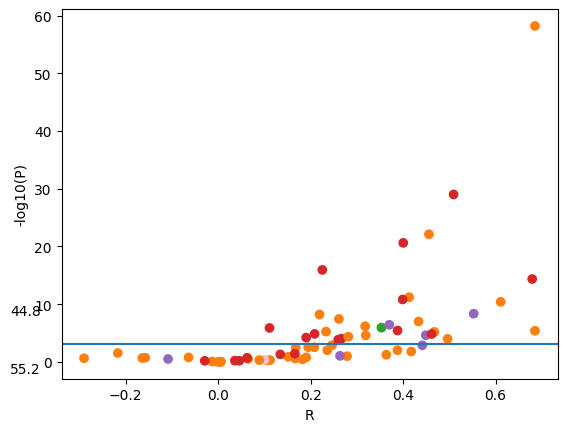

In [ ]:
# Create a figure of the -log10(p-value) vs. the correlation coefficients for the left-side gene expression vs the junction expression
plt.scatter(x = [i[0] for i in lefts], y = [-np.log10(i[1]) for i in lefts], c = [colors[filtered.loc[filtered.dataset == i, 'phylum'].iloc[0]] for i in datasets]) #Plot the left gene expression vs junction expression
plt.xlabel('R') #Label the x axis
plt.ylabel('-log10(P)') #Label the y axis
thresh = -np.log10(0.05/N) #Set the threshold for the legend
plt.axhline(thresh) # Plot a horizontal line at the threshold
sign = np.mean([-np.log10(i[1]) > thresh for i in lefts]) #Calculate the sign of the correlation
non_sign = np.mean([-np.log10(i[1]) <= thresh for i in lefts])
plt.text(x = -0.45, y = thresh + 5,fontsize = 10, 
         s  = round(sign * 100, 1 )) #Add the sign of the correlation to the plot
plt.text(x = -0.45, y = thresh - 5,fontsize = 10,
         s  = round(non_sign, 3) * 100)

Text(-0.45, -1.8728952016351923, '37.3')

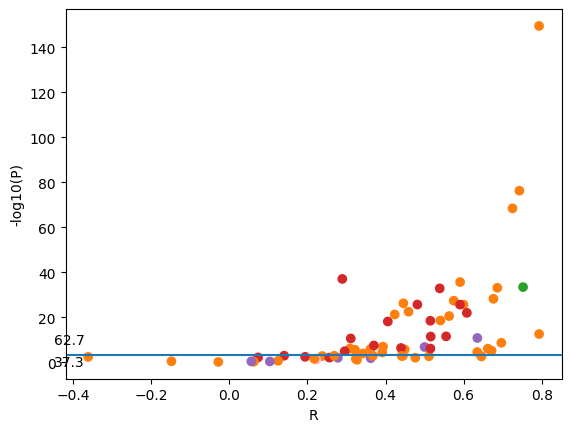

In [ ]:
# Create a figure of the -log10(p-value) vs. the correlation coefficients for the right-side gene expression vs the junction expression
plt.scatter(x = [i[0] for i in rights], y = [-np.log10(i[1]) for i in rights], c = [colors[filtered.loc[filtered.dataset == i, 'phylum'].iloc[0]] for i in datasets]) # Plot the right gene expression vs junction expression
plt.xlabel('R') 
plt.ylabel('-log10(P)')
thresh = -np.log10(0.05/len(datasets))
plt.axhline(thresh)
sign = np.mean([-np.log10(i[1]) > thresh for i in rights])
non_sign = np.mean([-np.log10(i[1]) <= thresh for i in rights])
plt.text(x = -0.45, y = thresh + 5,fontsize = 10,
         s  = round(sign, 3) * 100)
plt.text(x = -0.45, y = thresh - 5,fontsize = 10,
         s  = round(non_sign, 3) * 100)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


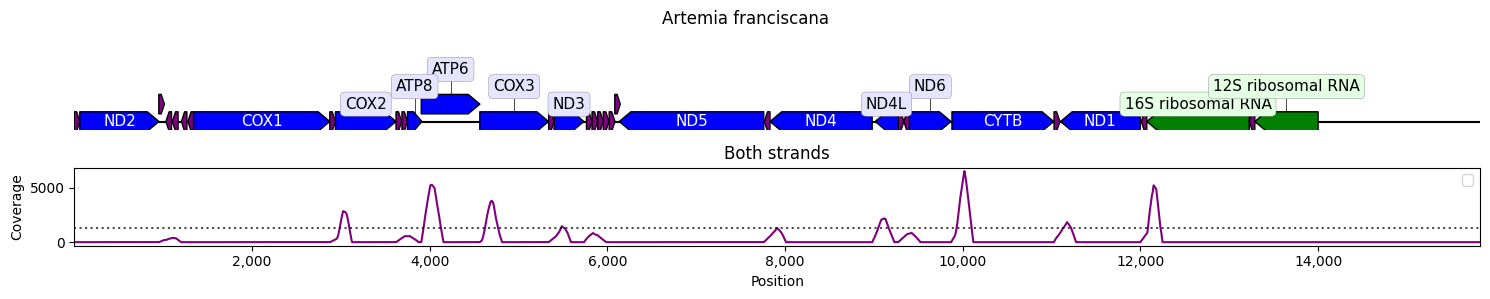

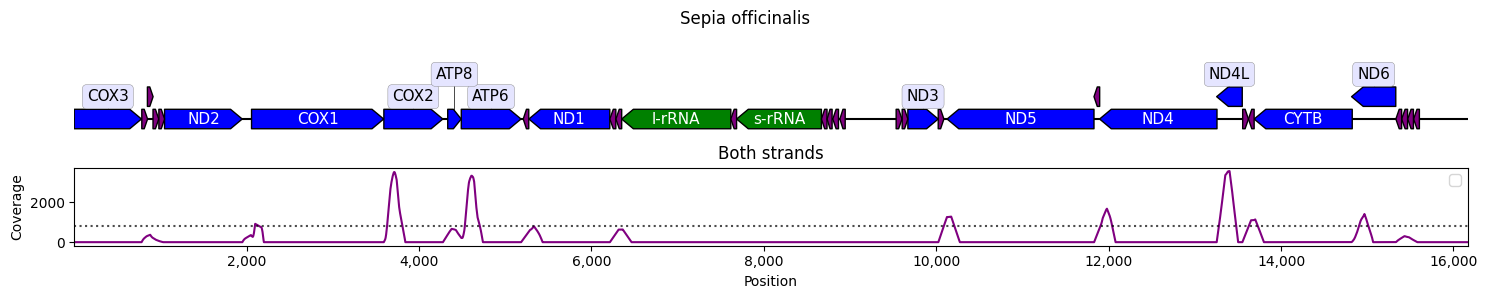

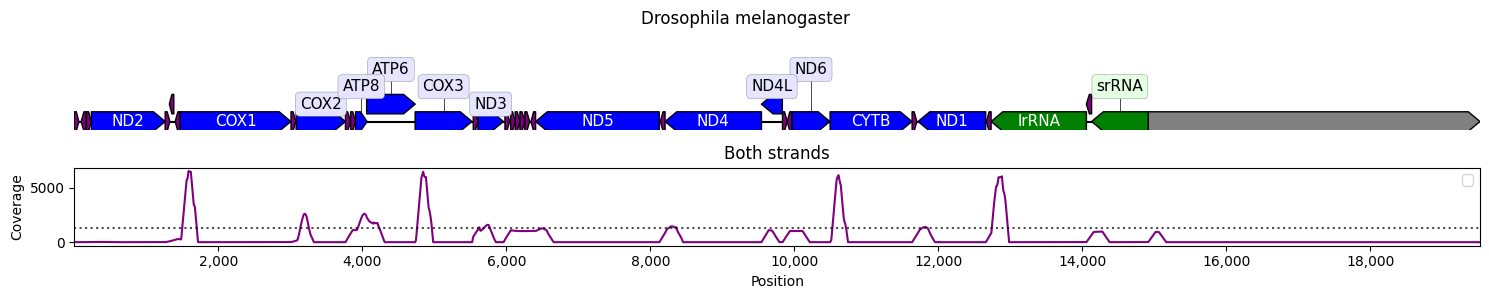

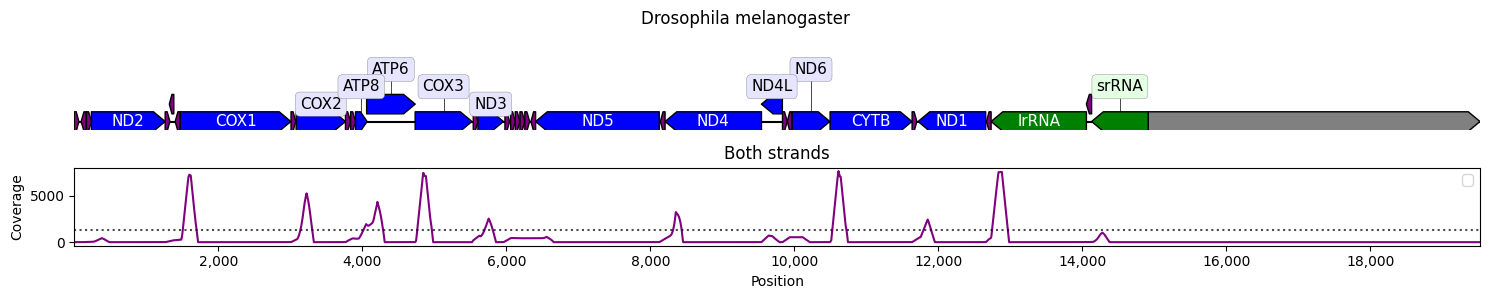

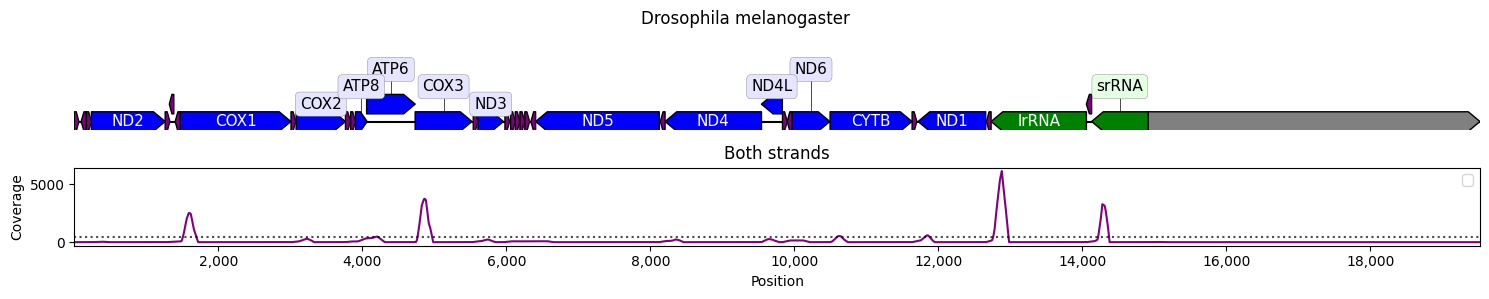

In [ ]:
# Generate plots of per-position expression for the junctions, aggregated by mean across samples and split by dataset.

utils.get_org_filtered_expr('Artemia_franciscana', filtered = True, plotlist = ['coverage'], window = 150, hline = 'mean')
utils.get_org_filtered_expr('Sepia_officinalis', filtered = True, plotlist = ['coverage'], window = 150, hline = 'mean')
utils.get_org_filtered_expr('Drosophila_melanogaster', filtered = True, plotlist = ['coverage'], window = 150, hline = 'mean')

There are 61 organisms in the database
from 1242 different samples


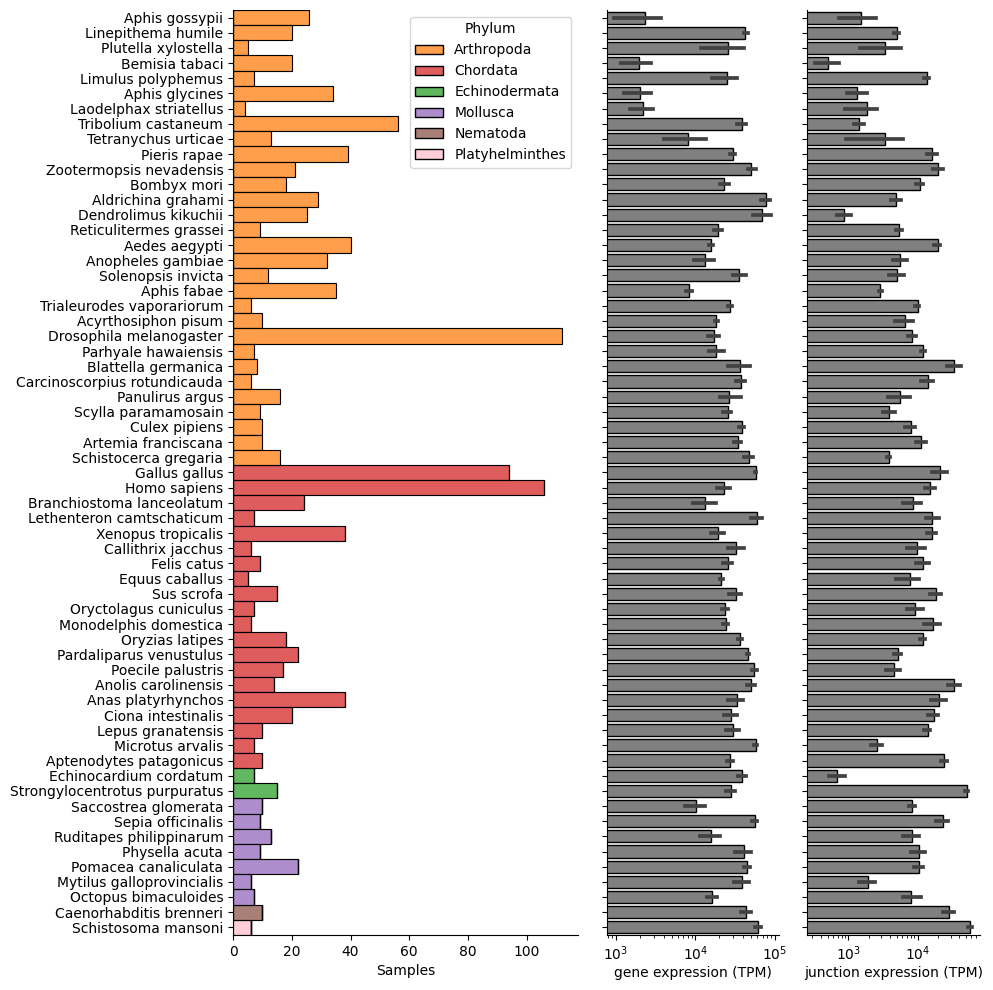

In [ ]:
###################
# Sample QC plots #
###################
reload(utils)

#FIGURE 3b - Sample count summary
plt.style.use('default')

_, axes = plt.subplots(1, 3, figsize = (5 * 2, 10), sharey = True, gridspec_kw = {'width_ratios': [1, 0.5, 0.5]})
temp = filtered.groupby('sample').agg({
    'org':'first', 'dataset':'first', 'gpair':'count', 'phylum':'first', 'left_tpm_raw' : 'median', 'junc_tpm_raw' : 'median'})
temp.to_csv('sample_counts.csv')
temp = temp.sort_values(by = 'phylum', ascending = True)
temp = temp.apply(lambda x: x.astype('category'), axis = 1)
temp = temp.rename({'phylum':'Phylum'}, axis = 1)
temp.org = temp.org.str.replace('_', ' ')
sns.histplot(data = temp, y = 'org', hue = 'Phylum', multiple = 'stack', palette = colors, legend = True, ax = axes[0], discrete= True, edgecolor = 'black')
sns.barplot(data = temp, y = 'org', x = 'left_tpm_raw', color = 'grey', ax = axes[1], edgecolor = 'black')
sns.barplot(data = temp, y = 'org', x = 'junc_tpm_raw', color = 'grey', ax = axes[2], edgecolor = 'black')
plt.xticks(rotation = 90)
axes[0].set(ylabel = '', xlabel = 'Samples')
axes[1].set_ylabel(ylabel = '')
axes[2].set_ylabel(ylabel = '')
axes[1].set_xlabel('gene expression (TPM)', fontsize = 10, labelpad = 2)
axes[2].set_xlabel('junction expression (TPM)', fontsize = 10, labelpad = 2)

# Scale axes[1] x to log
axes[1].set_xscale('log')
axes[2].set_xscale('log')

# Rotate x labels
for ax in axes:
    ax.tick_params(axis = 'x', rotation = 0)
    # Despine the right and top axes
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

print(f'There are {len(filtered.org.unique())} organisms in the database\nfrom {len(temp)} different samples')
plt.tight_layout()
plt.savefig(r'C:\Users\noam1\Desktop\The dynamics of the mitochondrial genome (paper prep)\final_figures\supp_fig_s3_all_rnaseq_samples.svg', dpi = 300)

In [ ]:
filtered.columns

Index(['gpair', 'org', 'coexpression', 'left_tpm', 'right_tpm', 'left_rpkm',
       'right_rpkm', 'right_gene', 'left_gene', 'left_strand', 'right_strand',
       'neigh_freq', 'strand_switch', 'Chromosome', 'junction_size',
       'sum_around_junction', 'Position', 'last_Position', 'count_Position',
       'mean_RPM', 'median_RPM', 'mean_coverage', 'median_coverage', 'mean_z',
       'median_z', 'mean_ends_ratio', 'max_ends_ratio', 'dataset',
       'junc_counts', 'glengths', 'junc_tpm', 'junc_rpkm', 'junc_tpm_z',
       'junc_rpkm_z', 'left_z', 'right_z', 'junc_tpm_mm', 'junc_rpkm_mm',
       'left_mm', 'right_mm', 'exp_diff', 'sample', 'z_around_junc',
       'z_around_junc_diff', 'organism', 'kingdom', 'phylum', 'class', 'order',
       'family', 'genus', 'Gene_order', 'junc_deseq', 'left_tpm_raw',
       'right_tpm_raw', 'left_rpkm_raw', 'right_rpkm_raw', 'junc_tpm_raw',
       'junc_rpkm_raw'],
      dtype='object')

In [ ]:
# Plot the distrbution of coverage for each organism


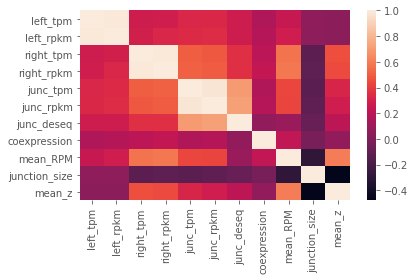

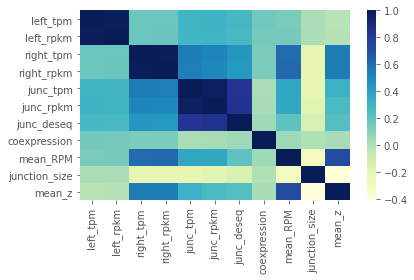

In [ ]:
# All 
sns.heatmap(filtered[['left_tpm','left_rpkm','right_tpm','right_rpkm',
                      'junc_tpm','junc_rpkm','junc_deseq','coexpression',
                      'mean_RPM', 'junction_size', 'mean_z']].corr(method = 'spearman'))
plt.tight_layout()
plt.show()
sns.heatmap(filtered.loc[filtered.phylum == 'Arthropoda', ['left_tpm','left_rpkm','right_tpm','right_rpkm',
                      'junc_tpm','junc_rpkm','junc_deseq','coexpression',
                      'mean_RPM', 'junction_size', 'mean_z']].corr(method = 'spearman'), cmap = 'YlGnBu')
plt.tight_layout()
plt.show()


In [ ]:
test = filtered.copy()
test['norm_junc'] = test['junc_tpm'] / test[['left_tpm', 'right_tpm']].sum(axis = 1)

In [ ]:
test[['left_tpm', 'right_tpm']].mean(axis = 1)

0        15.050014
1        10.092619
2         8.434962
3        10.734471
4         8.352074
           ...    
17560    14.713802
17561    11.747518
17562    11.460396
17565    15.355692
17566    13.860224
Length: 15404, dtype: float64

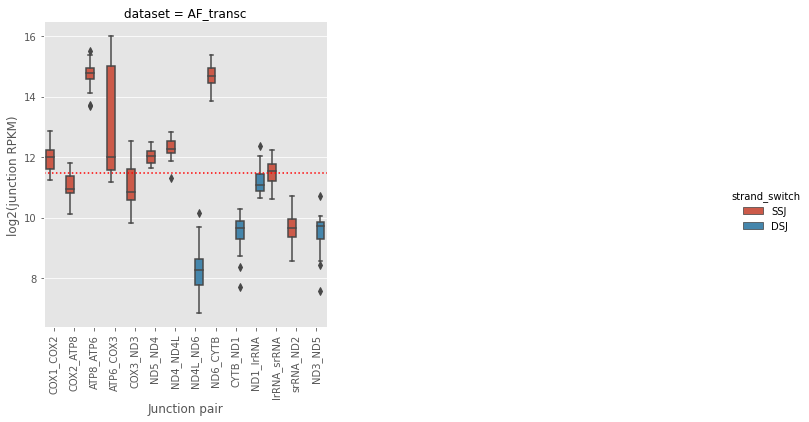

In [ ]:

gpairs = sns.catplot(kind = 'box', x = 'gpair', y = 'junc_tpm',
            data = test.loc[test.org == 'Aphis_fabae'],
                     col = 'dataset', sharex = False, sharey = False, hue = 'strand_switch', col_wrap = 2)
mean_list = utils.get_medians(test.loc[test.org == 'Aphis_fabae', :], 'dataset', 'junc_tpm')
for ax, pos in zip(gpairs.axes.flat, mean_list):
    ax.axhline(y = pos, color = 'r', linestyle = ':')
gpairs.set(xlabel = 'Junction pair', ylabel = 'log2(junction RPKM)')
gpairs.set_xticklabels(rotation = 90)
gpairs.tight_layout
plt.subplots_adjust(hspace=0.4, wspace=0.4)

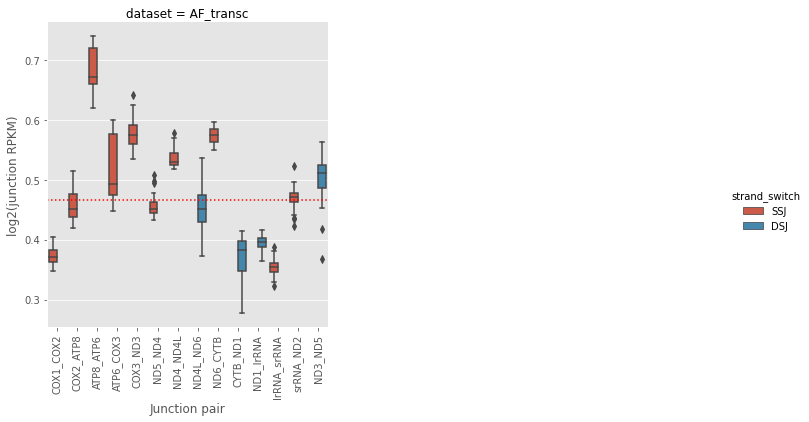

In [ ]:

gpairs = sns.catplot(kind = 'box', x = 'gpair', y = 'norm_junc',
            data = test.loc[test.org == 'Aphis_fabae'],
                     col = 'dataset', sharex = False, sharey = False, hue = 'strand_switch', col_wrap = 2)
mean_list = utils.get_medians(test.loc[test.org == 'Aphis_fabae', :], 'dataset', 'norm_junc')
for ax, pos in zip(gpairs.axes.flat, mean_list):
    ax.axhline(y = pos, color = 'r', linestyle = ':')
gpairs.set(xlabel = 'Junction pair', ylabel = 'log2(junction RPKM)')
gpairs.set_xticklabels(rotation = 90)
gpairs.tight_layout
plt.subplots_adjust(hspace=0.4, wspace=0.4)

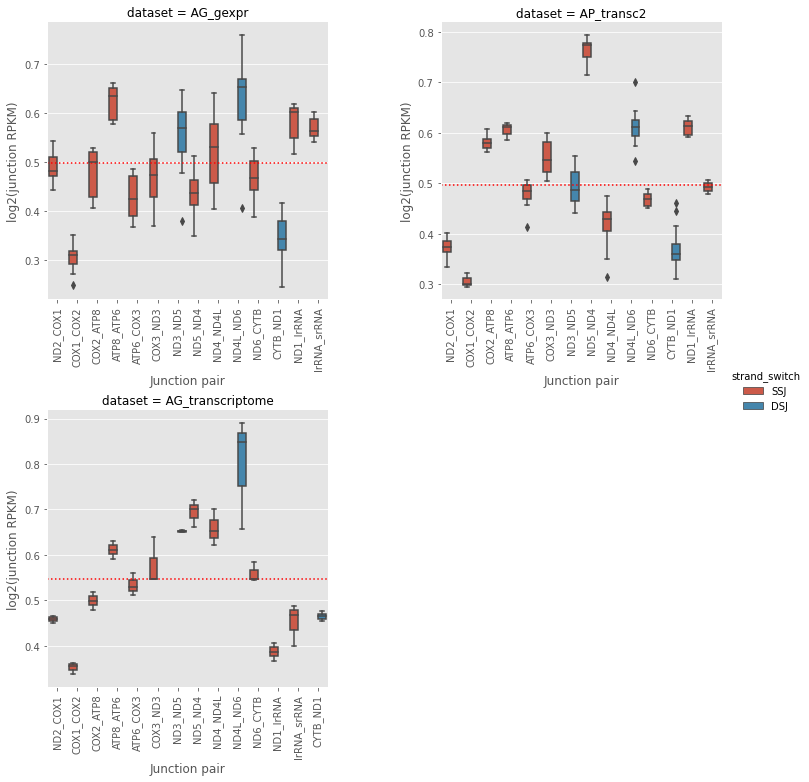

In [ ]:

gpairs = sns.catplot(kind = 'box', x = 'gpair', y = 'norm_junc',
            data = test.loc[test.org == 'Aphis_glycines'],
                     col = 'dataset', sharex = False, sharey = False, hue = 'strand_switch', col_wrap = 2)
mean_list = utils.get_medians(test.loc[test.org == 'Aphis_glycines', :], 'dataset', 'norm_junc')
for ax, pos in zip(gpairs.axes.flat, mean_list):
    ax.axhline(y = pos, color = 'r', linestyle = ':')
gpairs.set(xlabel = 'Junction pair', ylabel = 'log2(junction RPKM)')
gpairs.set_xticklabels(rotation = 90)
gpairs.tight_layout
plt.subplots_adjust(hspace=0.4, wspace=0.4)

C:\Users\noam1\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


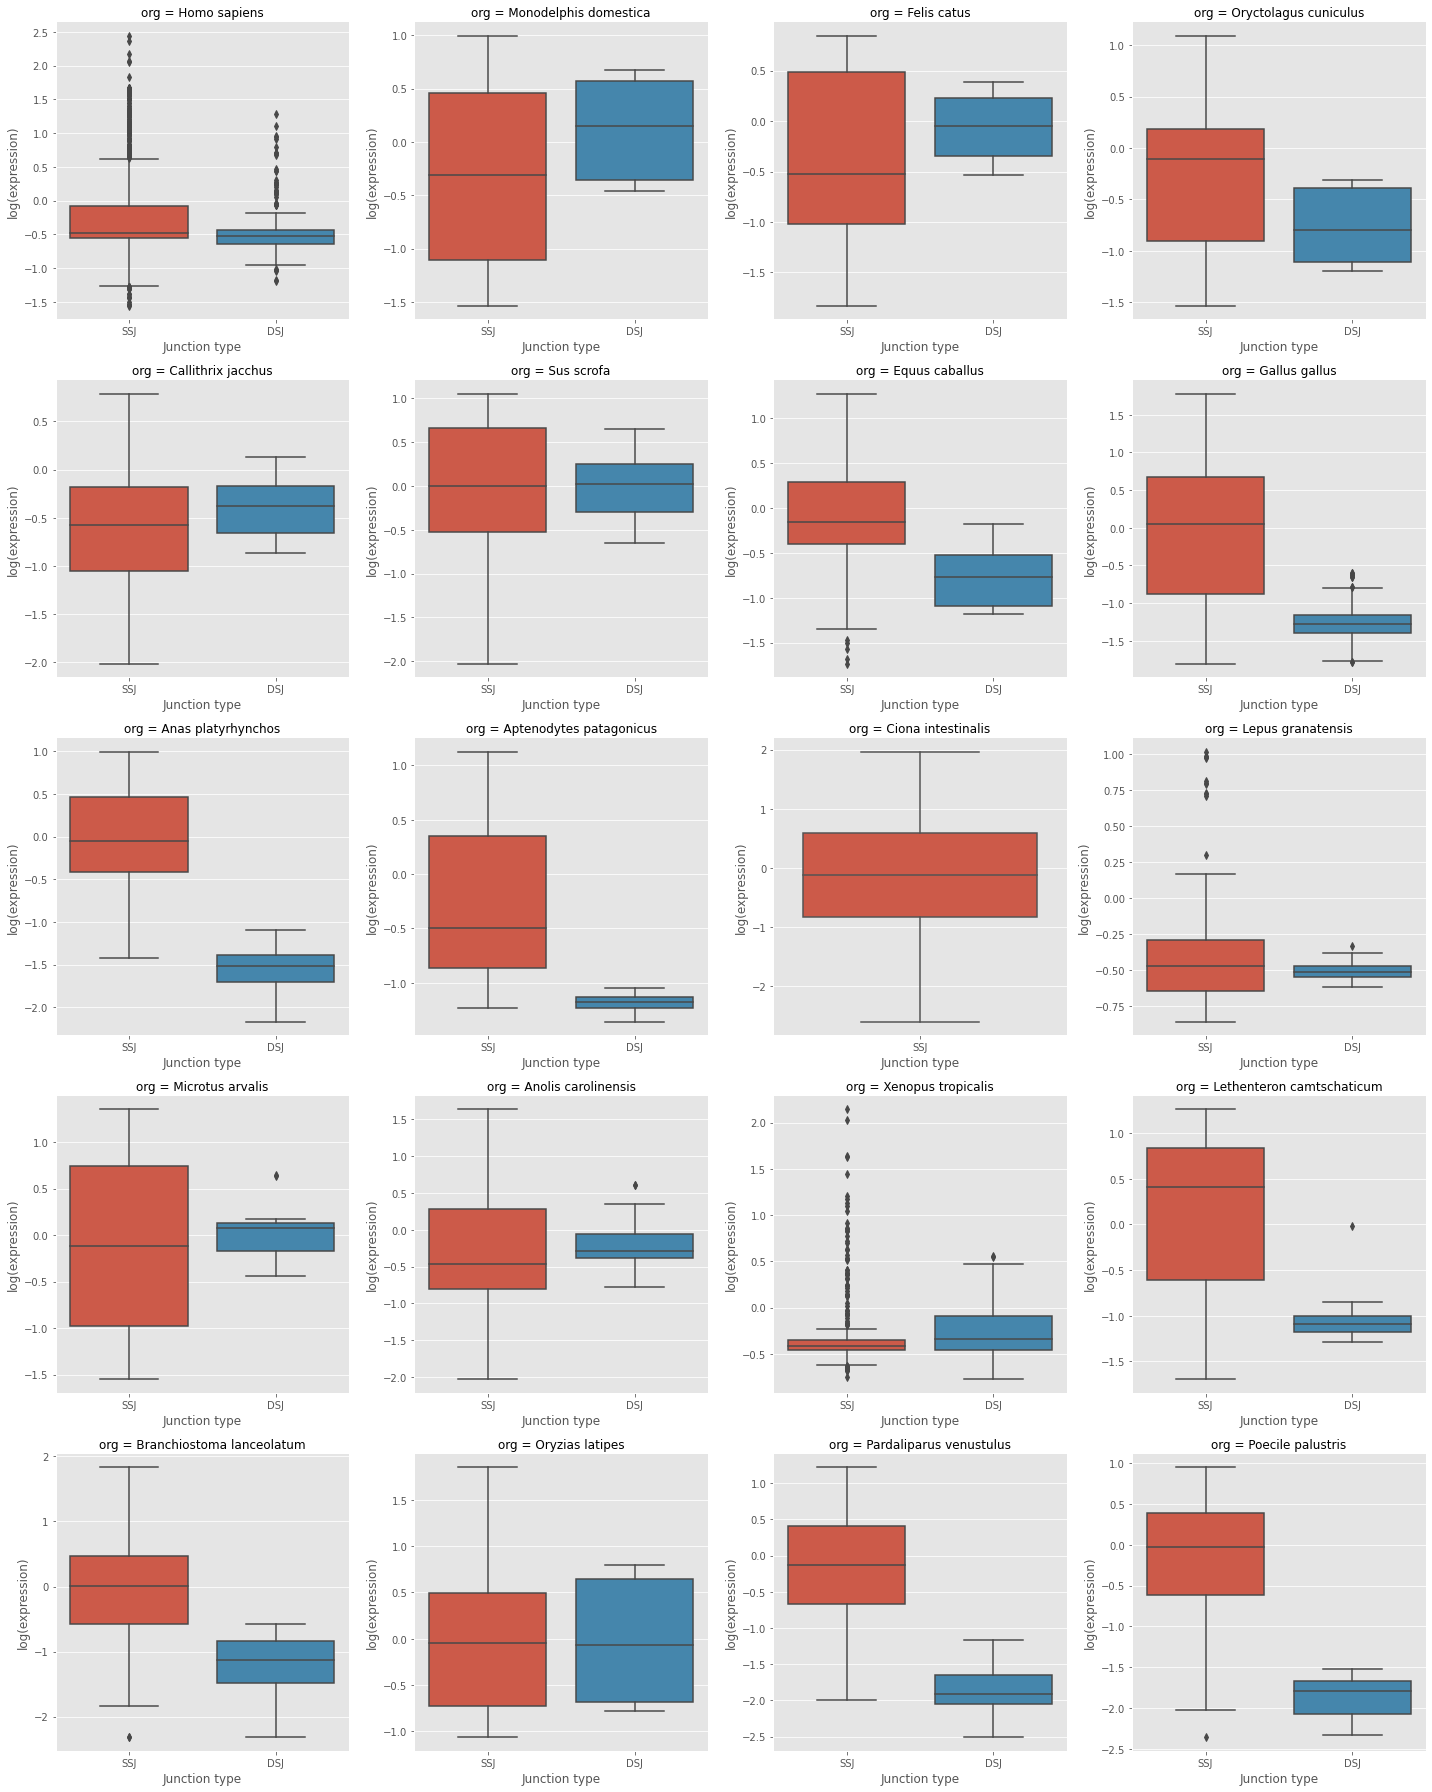

In [ ]:

%matplotlib inline

rpm_plot = sns.catplot(kind = 'box', y = 'mean_z', x = 'strand_switch', data = filtered.replace({'_':' '}, regex = True)[filtered.phylum == 'Chordata'], col = 'org', col_wrap = 4, legend_out = True, legend = False, sharex = False, sharey = False)

rpm_plot.set(xlabel = 'Junction type', ylabel = 'log(expression)')


rpm_plot.tight_layout()
#Average junction reads


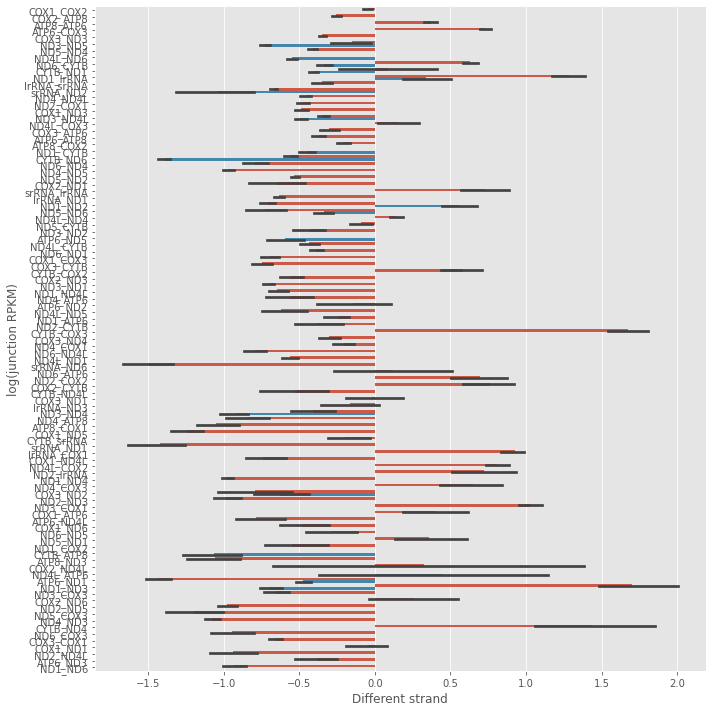

In [ ]:
%matplotlib inline

rpm_plot = sns.catplot(kind = 'bar', x = 'mean_z', y = 'gpair', hue = 'strand_switch', data = filtered,
                       legend_out = True, legend = False, sharex = False, sharey = False, orient = 'h', height = 10)

rpm_plot.set(xlabel = 'Different strand', ylabel = 'log(junction RPKM)')
rpm_plot.tight_layout()


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.228e-20 U_stat=5.928e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.028e-16 U_stat=1.258e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.171e-06 U_stat=1.487e+04


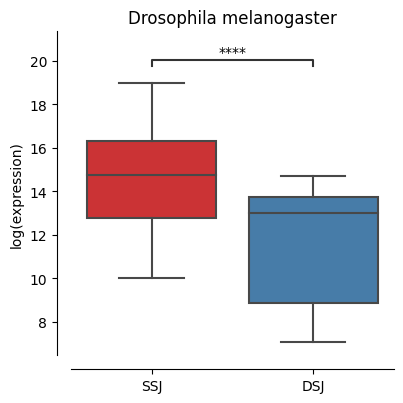

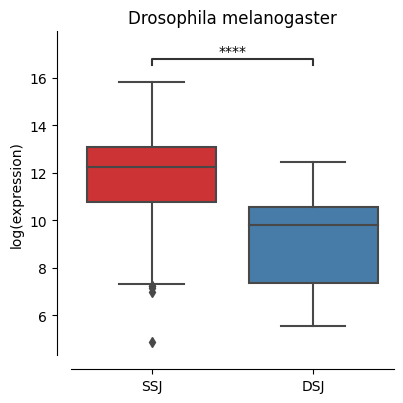

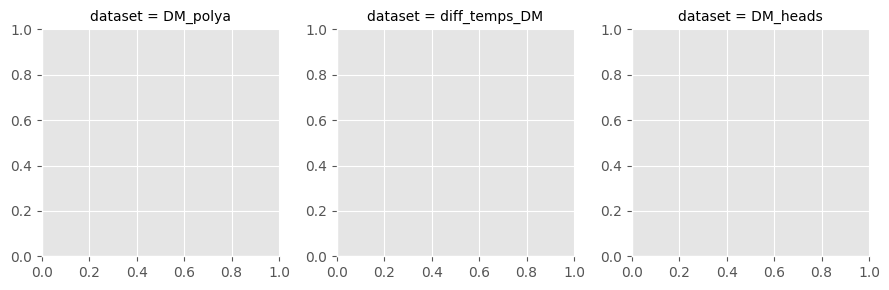

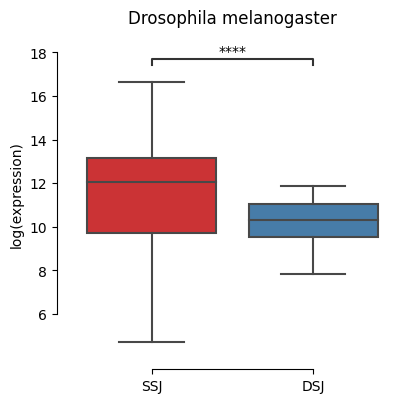

In [ ]:
#Fig 3C
reload(utils)
dros = filtered.loc[(filtered.org == 'Drosophila_melanogaster'), :]
dros_datasets = sns.FacetGrid(data =dros, col = 'dataset',
           sharex = False, sharey = False)
dros_datasets.map_dataframe(utils.custom_boxplot, x = 'strand_switch', y = 'junc_tpm', data = dros, palette = 'Set1', xlabel = '', savefig = True, style = 'default', despine = True)
sns.despine(trim = True, offset = 10)

# save figures
dros_datasets.savefig(r'C:\Users\noam1\Desktop\The dynamics of the mitochondrial genome (paper prep)\figures\dros_datasets.png', dpi = 300)



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.846e-11 U_stat=1.354e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.207e-02 U_stat=2.039e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.481e-01 U_stat=1.653e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s.

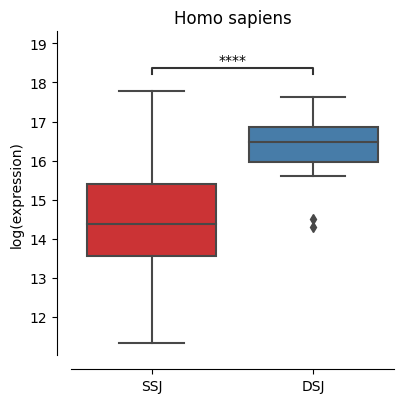

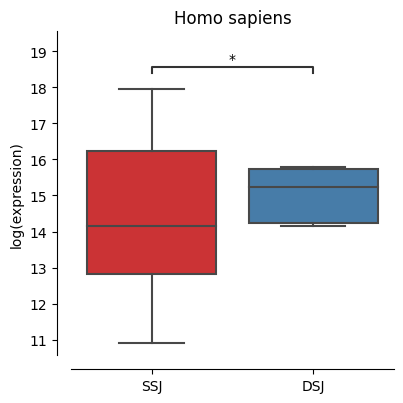

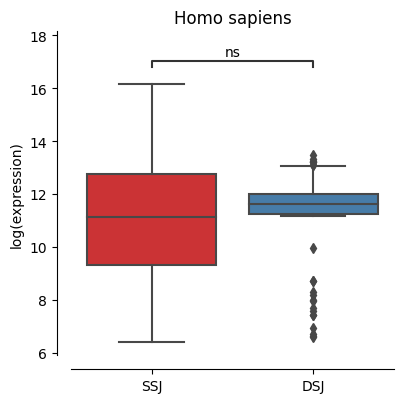

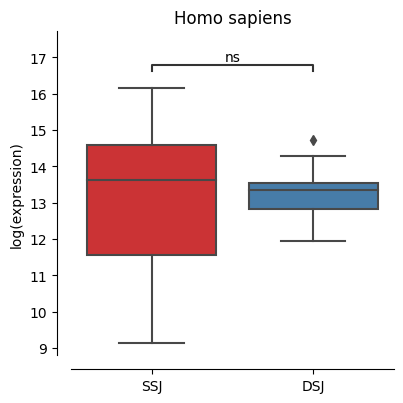

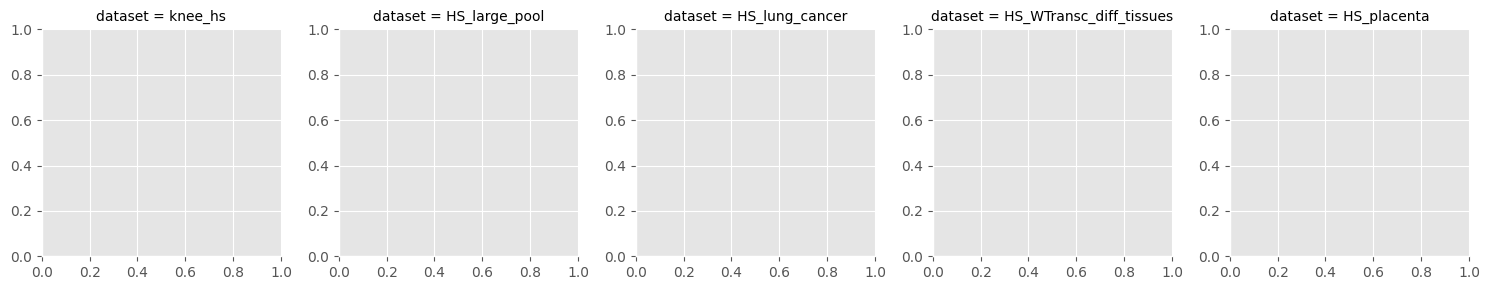

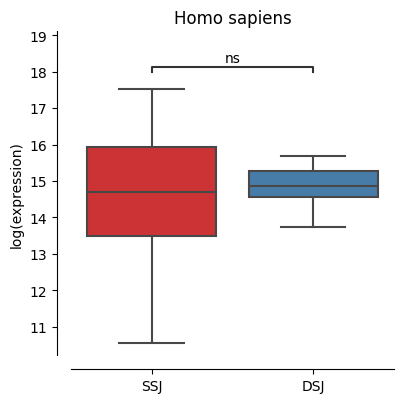

In [ ]:
#Fig 3C
reload(utils)
dros = filtered.loc[(filtered.org == 'Homo_sapiens'), :]
dros_datasets = sns.FacetGrid(data =dros, col = 'dataset',
           sharex = False, sharey = False)
dros_datasets.map_dataframe(utils.custom_boxplot, x = 'strand_switch', y = 'junc_tpm', data = dros, palette = 'Set1', xlabel = '', ylabel = 'log(expression)', savefig= True, style = 'default', despine = True)



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.177e-26 U_stat=6.190e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.846e-12 U_stat=1.174e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.282e-01 U_stat=1.151e+04


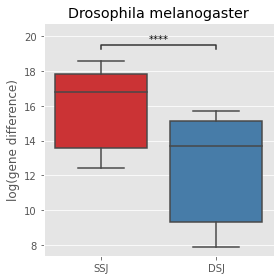

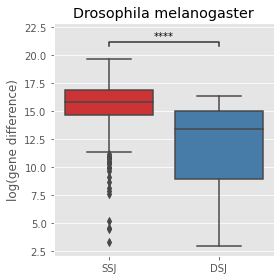

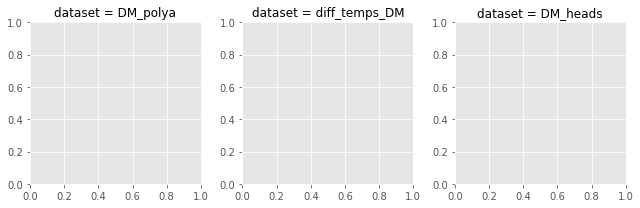

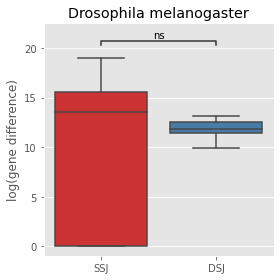

In [ ]:
#Fig 3C
reload(utils)
dros = filtered.loc[(filtered.org == 'Drosophila_melanogaster'), :]
dros_datasets = sns.FacetGrid(data =dros, col = 'dataset',
           sharex = False, sharey = False)
dros_datasets.map_dataframe(utils.custom_boxplot, x = 'strand_switch', y = 'exp_diff', data = dros, palette = 'Set1', xlabel = '', ylabel = 'log(gene difference)')



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.846e-11 U_stat=1.354e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.207e-02 U_stat=2.039e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.481e-01 U_stat=1.653e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s.

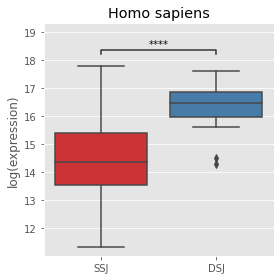

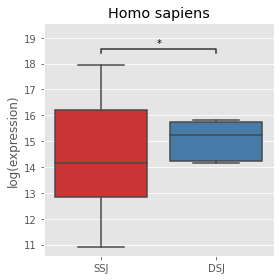

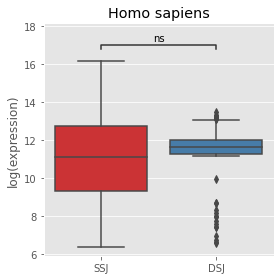

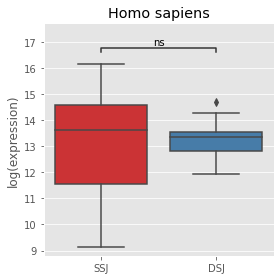

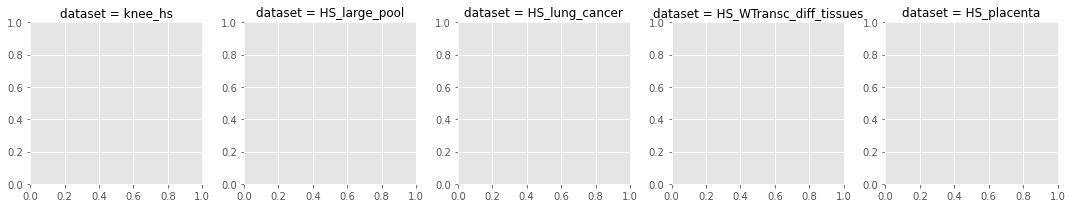

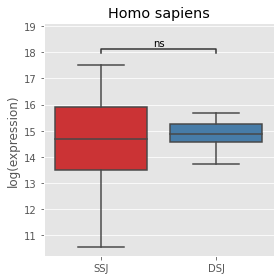

In [ ]:
#Fig 3C
reload(utils)
hs = filtered.loc[(filtered.org == 'Homo_sapiens'), :]
hs_datasets = sns.FacetGrid(data = hs, col = 'dataset',
           sharex = False, sharey = False)
hs_datasets.map_dataframe(utils.custom_boxplot, x = 'strand_switch', y = 'junc_tpm', data = hs, palette = 'Set1', xlabel = '')



In [ ]:
PATH = os.getcwd()
filtered = pd.read_csv(os.path.join(PATH, 'junctions_filtered_rerun.csv'))

uninteresting = [org for org in filtered.org.unique() if len(filtered.loc[(filtered['org'] == org) & (filtered['strand_switch'] == 'DSJ'), :]) == 0]
uninteresting

['Saccostrea_glomerata',
 'Caenorhabditis_brenneri',
 'Ciona_intestinalis',
 'Mytilus_galloprovincialis',
 'Schistosoma_mansoni',
 'Ruditapes_philippinarum',
 'Pomacea_canaliculata']

In [ ]:
#Figure 3D - all organism comparision
x = 'org'
y = 'junc_tpm'
hue = 'strand_switch'
def sort_x(value, x = 'org'):
    
    switched = to_plot.loc[(to_plot[x] == value) & (to_plot['strand_switch'] == 'DSJ'), y]
    not_switched = to_plot.loc[(to_plot[x] == value) & (to_plot['strand_switch'] == 'SSJ'), y]
    return mannwhitneyu(switched, not_switched, alternative='less').pvalue

%matplotlib inline 
to_plot = filtered.loc[~filtered.org.isin(uninteresting), :].replace({'_':' '}, regex= True)
order = sorted([i for i in to_plot.org.unique()], key = sort_x, reverse = False)
box_pairs = [((org, 'DSJ'),(org,'SSJ')) for org in to_plot.org.unique()]
fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(ax = ax, data = to_plot, y = y, x = x, hue = hue, orient = 'v', order = order)
ax, test_results = add_stat_annotation(ax, data = to_plot, y = y,
                    x = x, hue = hue, box_pairs = box_pairs, loc = 'inside', test = 'Mann-Whitney', verbose = 1,
                   text_format = 'star', comparisons_correction = 'bonferroni', order = order)

plt.xticks(rotation = 90, fontsize = 11)
plt.xlabel('Organism', fontsize = 16)
plt.ylabel('log(TPM)', fontsize = 16)
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.savefig(r'C:\Users\noam1\Desktop\The dynamics of the mitochondrial genome (paper prep)\figures\all_org_expr.pdf')


No handles with labels found to put in legend.
C:\Users\noam1\AppData\Local\Temp/ipykernel_2496/2921947301.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


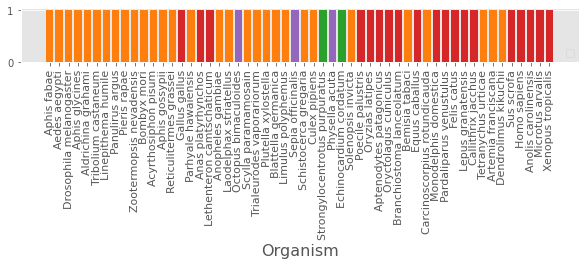

In [ ]:
_, ax = plt.subplots(figsize = (10, 1))
ax.bar(x = order, height = 1, color =  [PH_COLORS[to_plot.loc[to_plot.org == org, 'phylum'].iloc[0]] for org in order])
plt.xticks(rotation = 90, fontsize = 11)
plt.xlabel('Organism', fontsize = 16)
plt.legend(loc = 'lower right')
plt.tight_layout()


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Aphis gossypii_SSJ v.s. Aphis gossypii_DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.310e-07 U_stat=1.826e+04
Schistocerca gregaria_SSJ v.s. Schistocerca gregaria_DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.914e+03
Tetranychus urticae_SSJ v.s. Tetranychus urticae_DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.270e+02
Scylla paramamosain_SSJ v.s. Scylla paramamosain_DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.256e-03 U_stat=1.692e+03
Zootermopsis nevadensis_SSJ v.s. Zootermopsis nevadensis_DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.315e-07 U_stat=7.778e+03
Blattella germanica_SSJ v.s. Blattella germanica_DSJ: Mann-Whitney-Wilcoxo

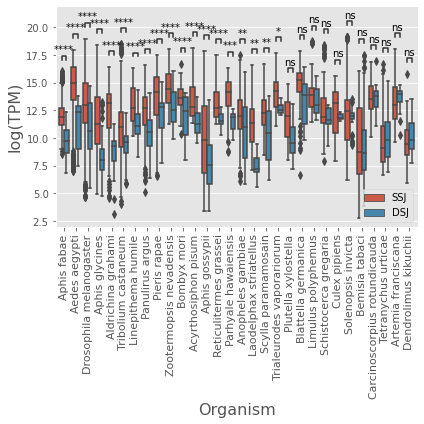

In [ ]:
x = 'org'
y = 'junc_tpm'
hue = 'strand_switch'

def sort_x(value, x = 'org'):
    
    switched = to_plot.loc[(to_plot[x] == value) & (to_plot['strand_switch'] == 'DSJ'), y]
    not_switched = to_plot.loc[(to_plot[x] == value) & (to_plot['strand_switch'] == 'SSJ'), y]
    return mannwhitneyu(switched, not_switched, alternative='less').pvalue

%matplotlib inline 
to_plot = filtered.loc[(filtered.org != '')
                       & (filtered.org != 'Ciona_intestinalis') & (filtered.org != 'Caenorhabditis_brenneri') & (filtered.phylum == 'Arthropoda'),
                       :].replace({'_':' '}, regex= True)
order = sorted([i for i in to_plot.org.unique()], key = sort_x, reverse = False)
box_pairs = [((org, 'DSJ'),(org,'SSJ')) for org in to_plot.org.unique()]
fig, ax = plt.subplots(figsize = (6,6))
sns.boxplot(ax = ax, data = to_plot, y = y, x = x, hue = hue, orient = 'v', order = order)
ax, test_results = add_stat_annotation(ax, data = to_plot, y = y,
                    x = x, hue = hue, box_pairs = box_pairs, loc = 'inside', test = 'Mann-Whitney', verbose = 1,
                   text_format = 'star', comparisons_correction = 'bonferroni', order = order)
plt.xticks(rotation = 90, fontsize = 11)
plt.xlabel('Organism', fontsize = 16)
plt.ylabel('log(TPM)', fontsize = 16)
plt.legend(loc = 'lower right')
plt.tight_layout()

No handles with labels found to put in legend.
C:\Users\noam1\AppData\Local\Temp/ipykernel_2496/2993252468.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


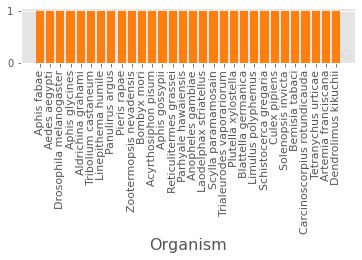

In [ ]:
_, ax = plt.subplots(figsize = (6, 1))
ax.bar(x = order, height = 1, color =  [PH_COLORS[to_plot.loc[to_plot.org == org, 'phylum'].iloc[0]] for org in order])
plt.xticks(rotation = 90, fontsize = 11)
plt.xlabel('Organism', fontsize = 16)
plt.legend(loc = 'lower right')
plt.tight_layout()


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.770e-08 U_stat=1.826e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.073e-02 U_stat=2.914e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.920e-01 U_stat=8.270e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s.

c:\Users\noam1\Desktop\Junctions model\dna_features_translator_class.py:358: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize = (15, 2.5))


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.698e-01 U_stat=1.123e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.310e-02 U_stat=3.940e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s. DSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.967e-07 U_stat=1.749e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SSJ v.s.

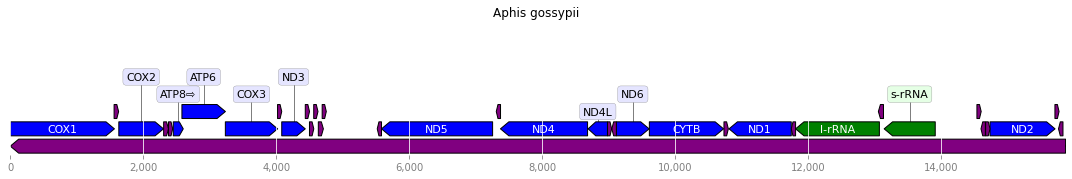

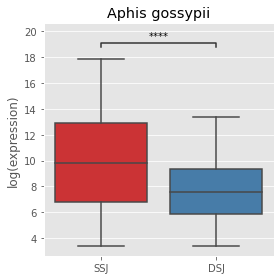

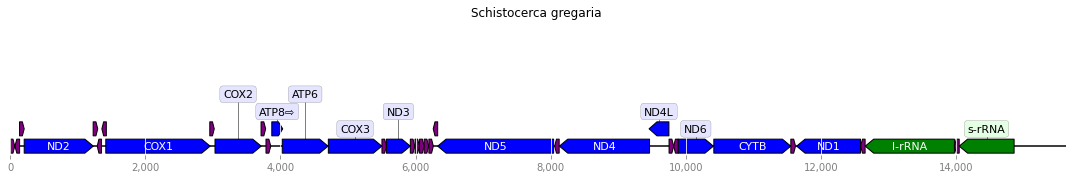

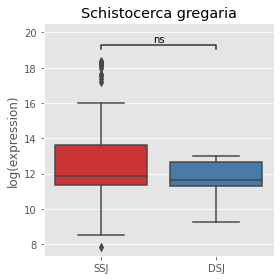

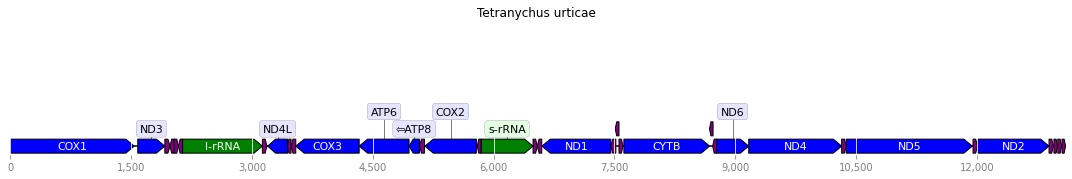

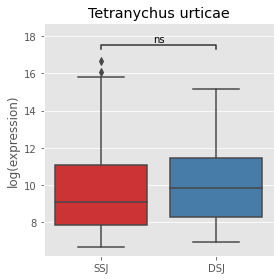

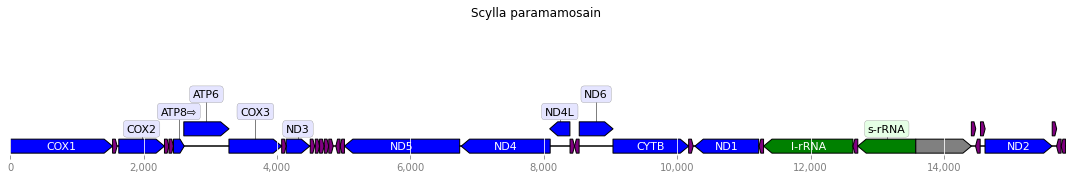

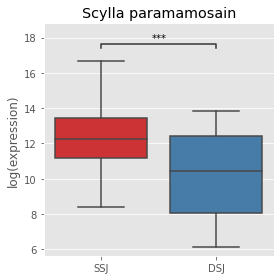

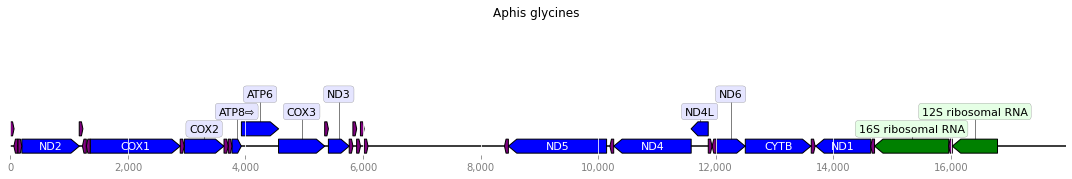

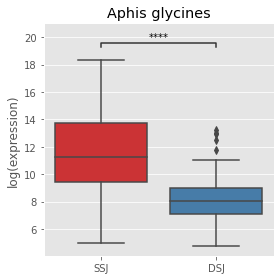

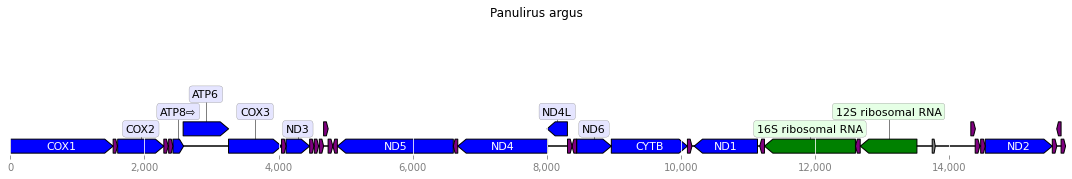

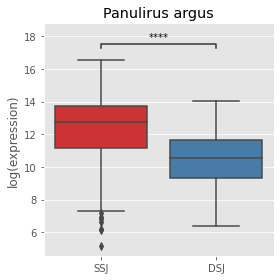

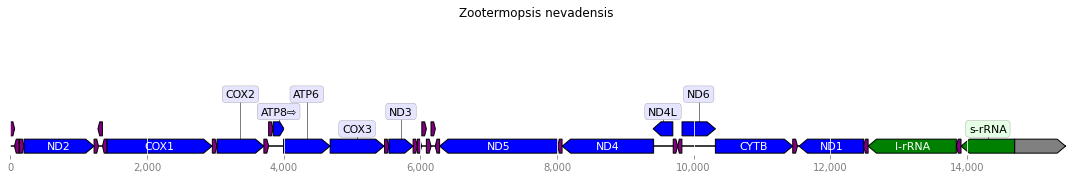

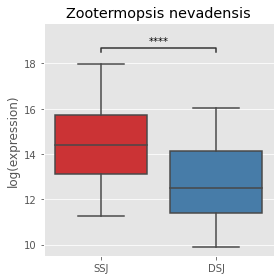

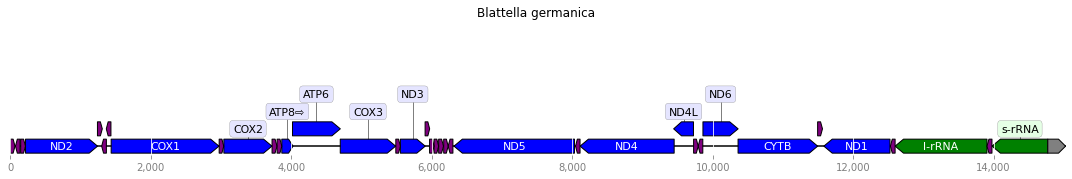

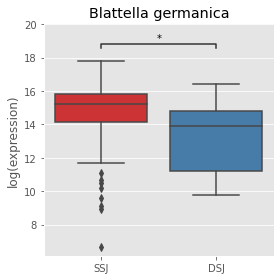

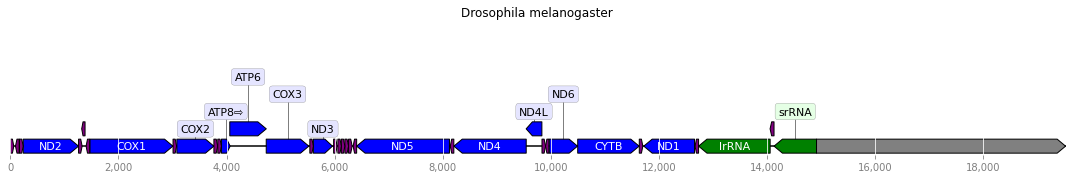

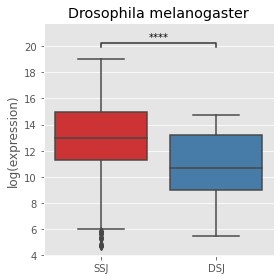

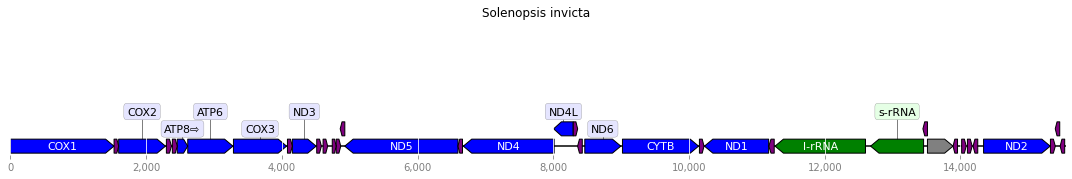

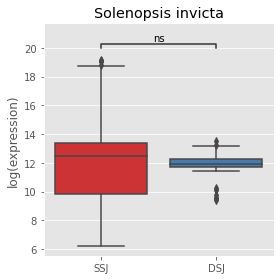

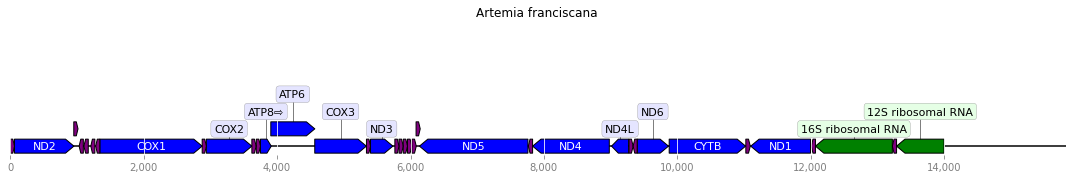

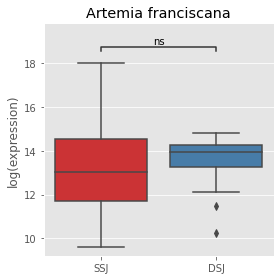

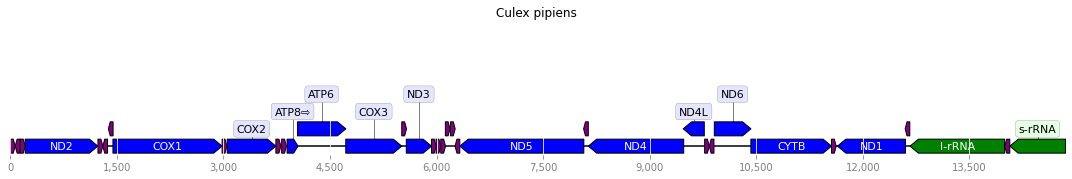

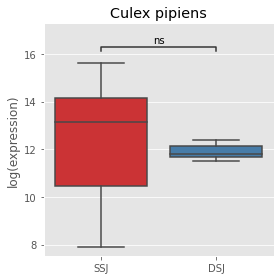

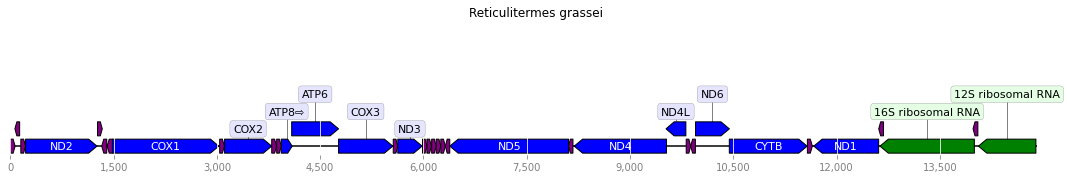

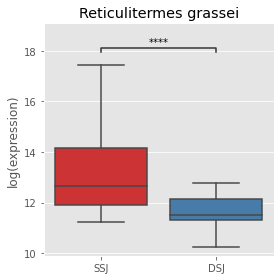

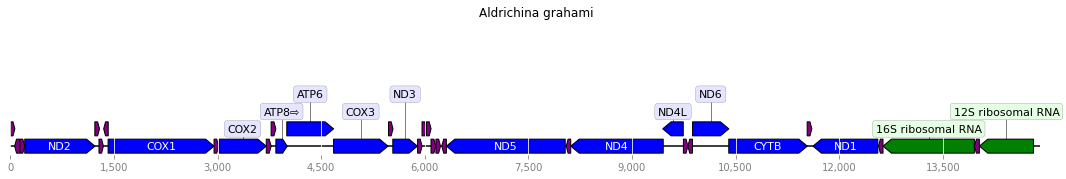

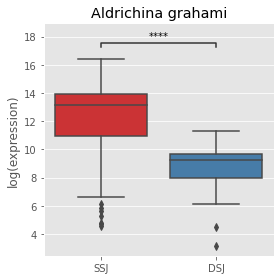

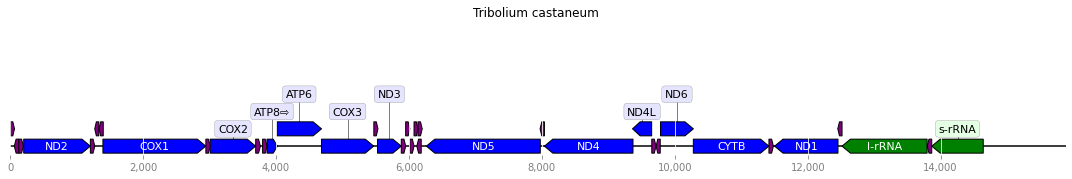

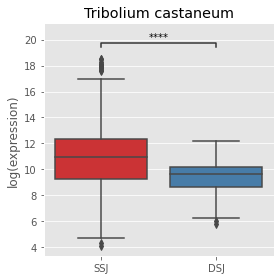

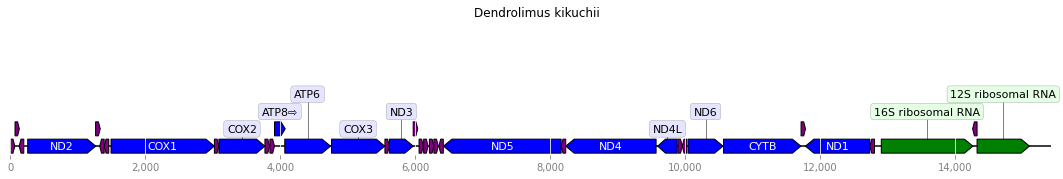

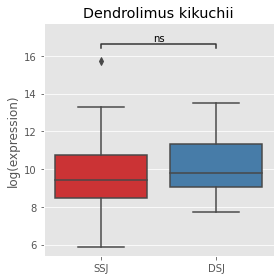

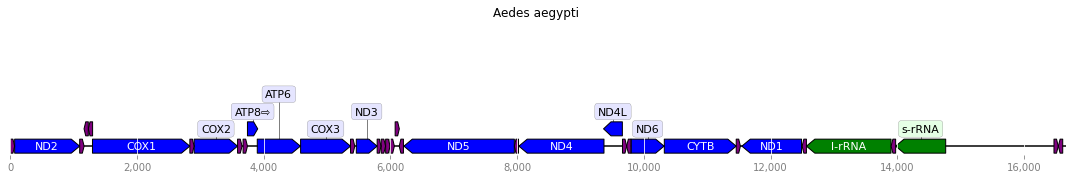

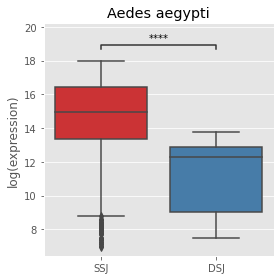

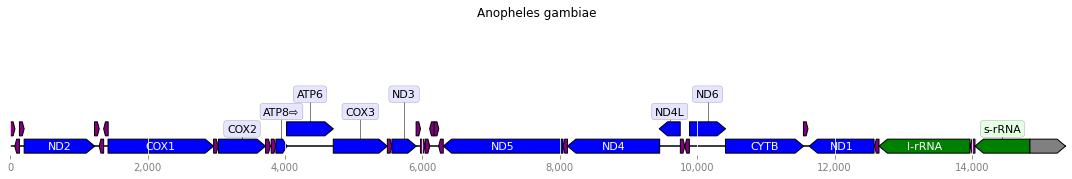

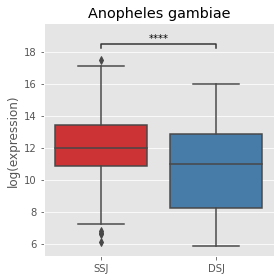

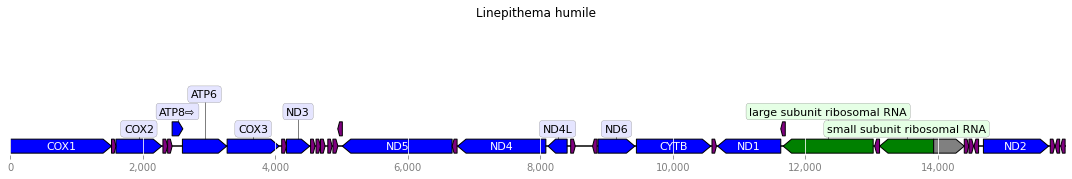

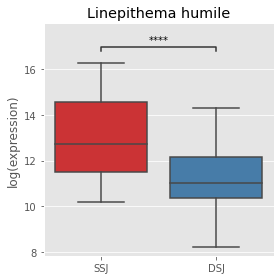

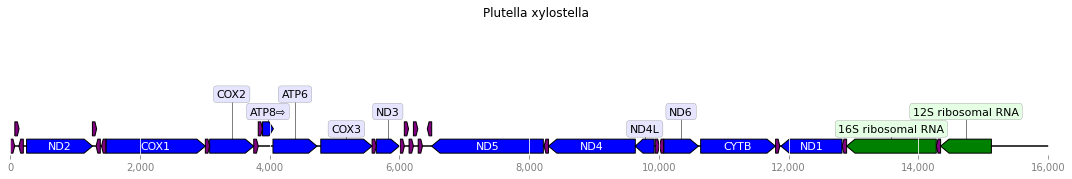

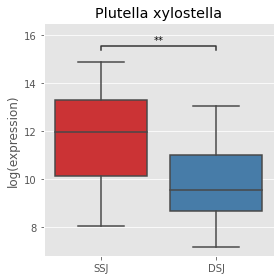

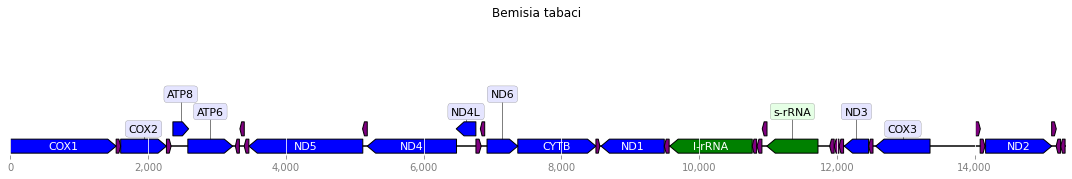

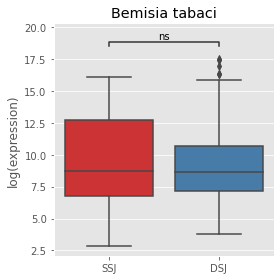

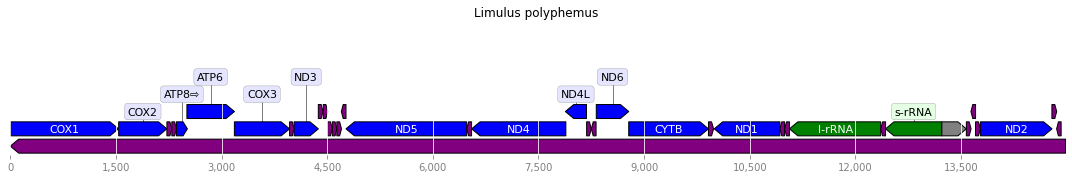

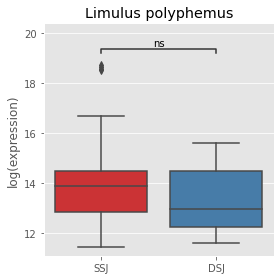

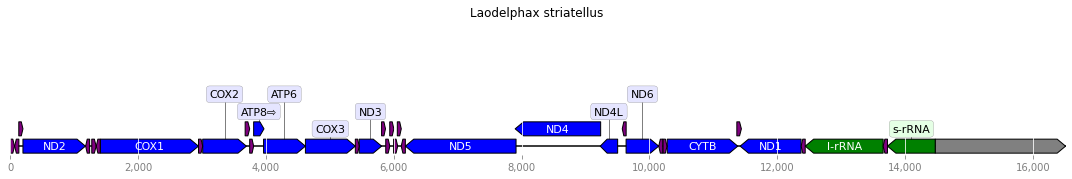

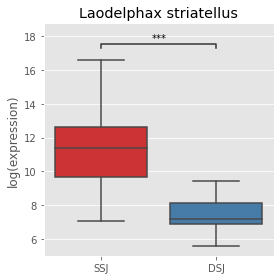

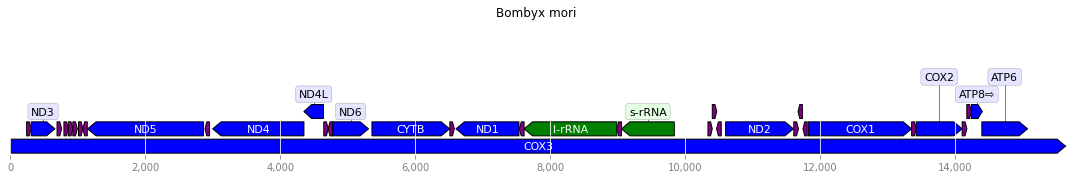

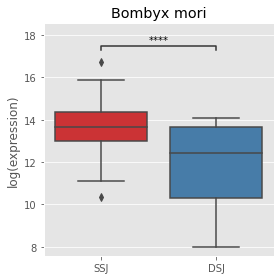

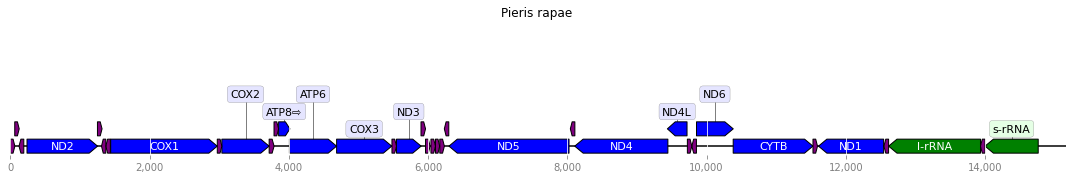

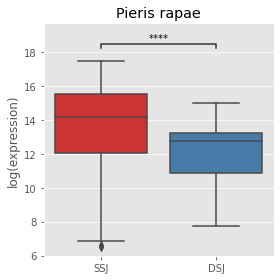

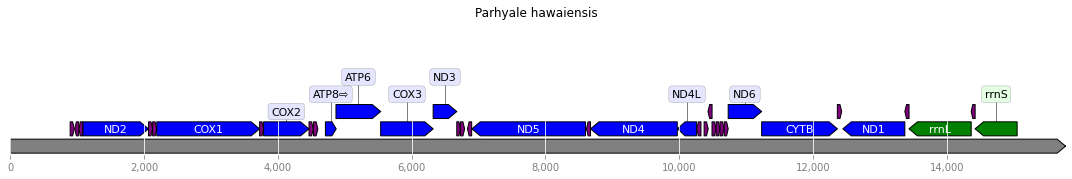

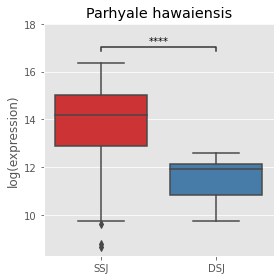

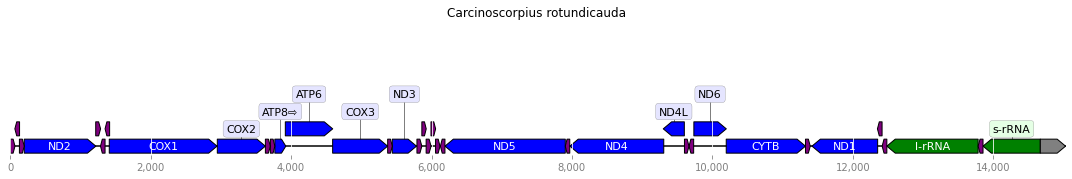

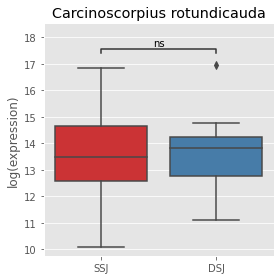

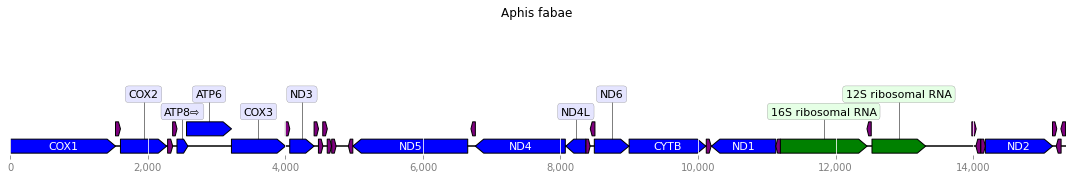

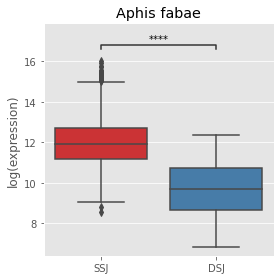

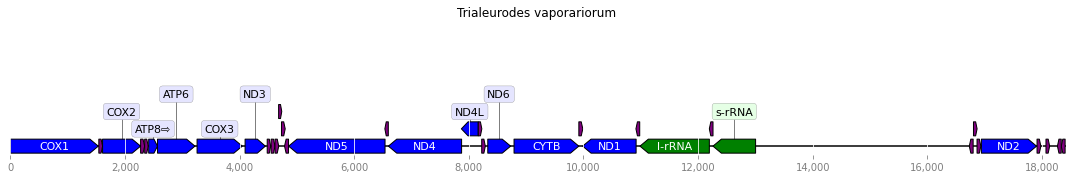

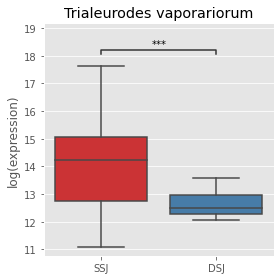

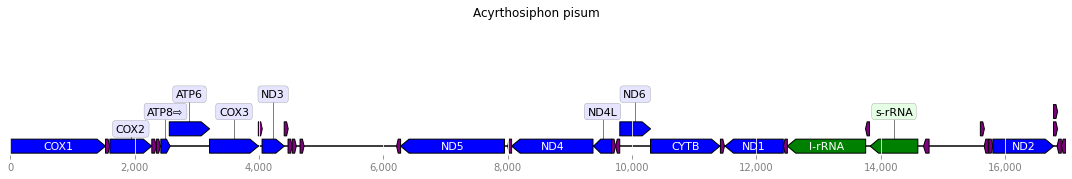

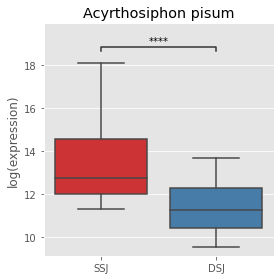

In [ ]:
for org in to_plot.org.unique():
    dftc.plot_gorder(org)
    utils.custom_boxplot(x = 'strand_switch', y = 'junc_tpm', data = to_plot[to_plot.org == org], palette = 'Set1', xlabel = '')

array(['Aphis gossypii', 'Schistocerca gregaria', 'Tetranychus urticae',
       'Scylla paramamosain', 'Aphis glycines', 'Panulirus argus',
       'Zootermopsis nevadensis', 'Blattella germanica',
       'Drosophila melanogaster', 'Solenopsis invicta',
       'Artemia franciscana', 'Culex pipiens', 'Reticulitermes grassei',
       'Aldrichina grahami', 'Tribolium castaneum',
       'Dendrolimus kikuchii', 'Aedes aegypti', 'Anopheles gambiae',
       'Linepithema humile', 'Plutella xylostella', 'Bemisia tabaci',
       'Limulus polyphemus', 'Laodelphax striatellus', 'Bombyx mori',
       'Pieris rapae', 'Parhyale hawaiensis',
       'Carcinoscorpius rotundicauda', 'Aphis fabae',
       'Trialeurodes vaporariorum', 'Acyrthosiphon pisum'], dtype=object)

C:\Users\noam1\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


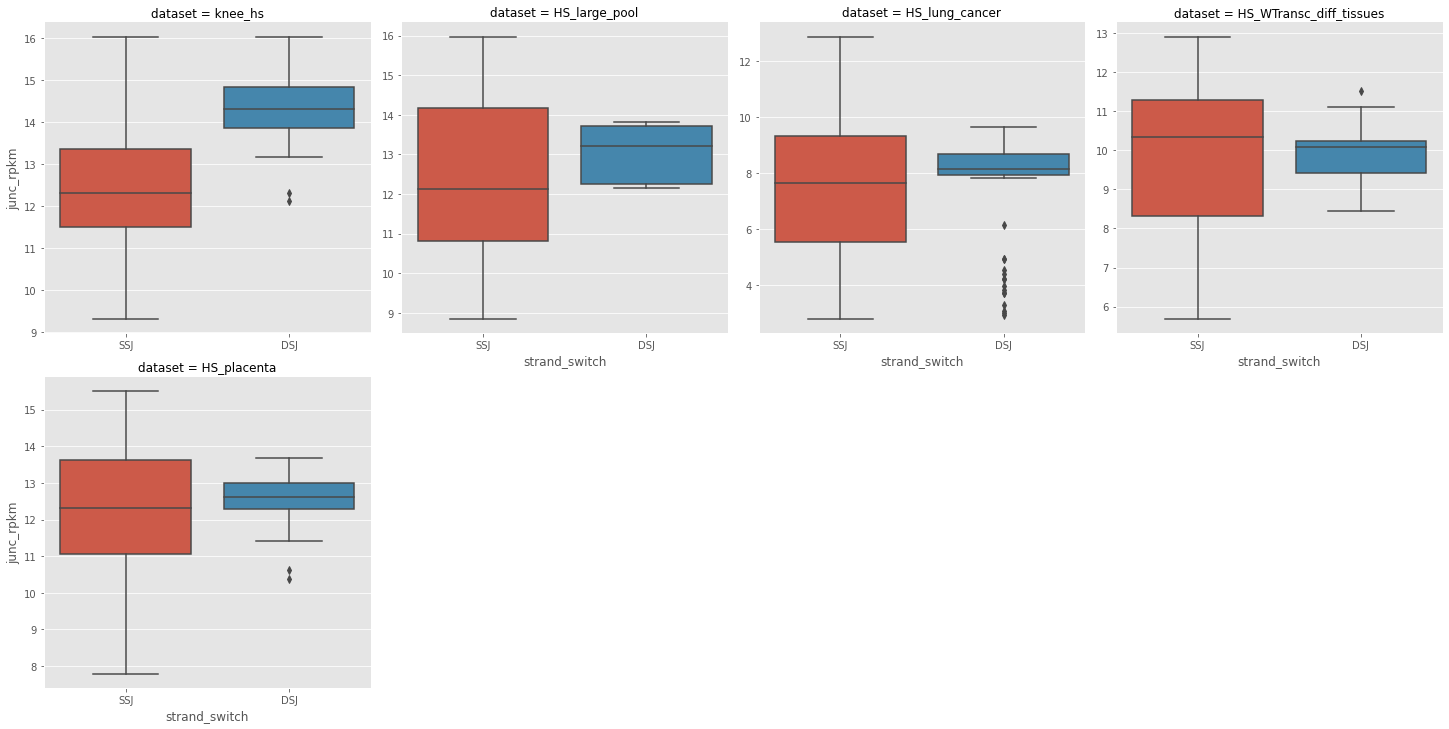

In [ ]:
display(to_plot.org.unique())
human = filtered.loc[filtered.org == 'Homo_sapiens', :]

human_datasets = sns.catplot(kind = 'box', y = 'junc_rpkm', x = 'strand_switch', data = human, col = 'dataset', col_wrap = 4,
           legend_out = True, legend = False, sharex = False, sharey = False)
dros_datasets.set(xlabel = 'Different strand', ylabel = 'log(junction RPKM)')
dros_datasets.tight_layout()


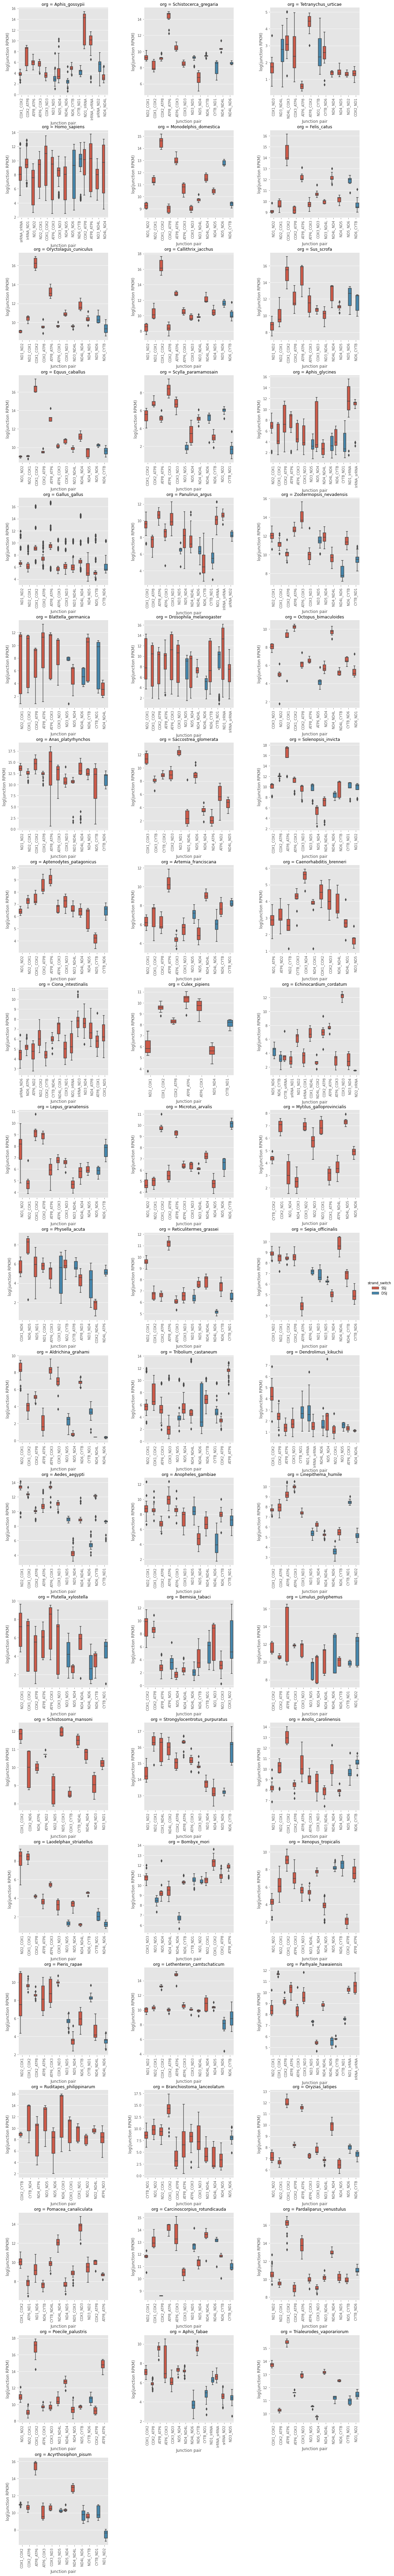

In [ ]:
gpairs = sns.catplot(kind = 'box', x = 'gpair', y = 'junc_deseq',
            data = filtered, col = 'org', col_wrap = 3, sharex = False, sharey = False, hue = 'strand_switch')
gpairs.set(xlabel = 'Junction pair', ylabel = 'log(junction RPKM)')
gpairs.set_xticklabels(rotation = 90)
gpairs.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ND6_CYTB_DSJ v.s. ND6_CYTB_SSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.046e-82 U_stat=1.289e+04
ND3_ND5_DSJ v.s. ND3_ND5_SSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.167e-09 U_stat=1.172e+03
CYTB_ND6_DSJ v.s. CYTB_ND6_SSJ: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.156e-16 U_stat=4.600e+01


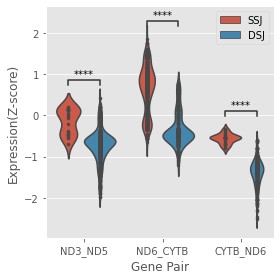

In [30]:
fig, ax = plt.subplots(figsize = (4,4))
interesting = ['CYTB_ND6', 'ND6_CYTB', 'ND3_ND5']
box_pairs = [((gpair, 'DSJ'),(gpair,'SSJ')) for gpair in interesting]
sns.violinplot(x = 'gpair',
            y = 'mean_z',
            hue = 'strand_switch',
            hue_order = ['SSJ', 'DSJ'],
            data = filtered.loc[filtered.gpair.isin(interesting)],
            kind = 'violin', 
            inner = 'point',
            legend = False, 
            ax = ax)
add_stat_annotation(ax = ax,
                    test = 'Mann-Whitney',
                    loc = 'inside',
                    data = filtered.loc[filtered.gpair.isin(interesting)],
                    text_format = 'star',
                    x = 'gpair',
                    y = 'mean_z',
                    hue = 'strand_switch',
                    box_pairs =  box_pairs)
plt.ylabel('Expression(Z-score)')
plt.xlabel('Gene Pair')
plt.legend()
plt.tight_layout()
plt.savefig(r'C:\Users\noam1\Desktop\The dynamics of the mitochondrial genome (paper prep)\figures\effect_of_strand_switch_on_expression.pdf')

In [ ]:
bins = [0,90,100]
labels = ['Unconserved', 'Conserved']
filtered['neigh_freq_cat'] = pd.cut(filtered['neigh_freq'], bins = bins, labels = labels)
neighs = filtered[['gpair','org', 'neigh_freq', 'neigh_freq_cat', 'junc_tpm', 'mean_z', 'junc_tpm_mm', 'strand_switch']]
neighs.neigh_freq = neighs.neigh_freq/100
neighs.head()

In [ ]:
sns.catplot(x = 'neigh_freq_cat', y = 'mean_z', data = neighs, hue = 'strand_switch', kind = 'violin')
plt.xlabel('Conservation level')
plt.ylabel('Expression (Z-score)')

In [ ]:
sns.catplot(x = 'neigh_freq_cat', y = 'mean_z', col_wrap = 3, col = 'org', data = neighs, hue = 'strand_switch', kind = 'violin')

In [ ]:

worm= set([i.replace('-','') for i in final.loc[['Caenorhabditis elegans'], 'Gene_order'].to_list()[0]])
hu= set([i.replace('-','') for i in final.loc[['Homo sapiens'], 'Gene_order'].to_list()[0]])

fly= set([i.replace('-','') for i in final.loc[['Drosophila melanogaster'], 'Gene_order'].to_list()[0]])

In [ ]:
pro = pd.read_csv('data\\annotated_pileup_proseq\\SRR1810071_4_HS.csv', index_col = 0)
pro2 =pd.read_csv('data\\annotated_pileup_proseq\\SRR1810071_4_HS_2.csv', index_col = 0)
pro3 = pd.read_csv('data\\annotated_pileup_proseq\\SRR1810071_4_HS_3.csv', index_col = 0)

In [ ]:
pro['pos_rolling'] = pro.pos_coverage.rolling(window = 200, min_periods = 1).mean()
pro['neg_rolling'] = pro.neg_coverage.rolling(window = 200, min_periods = 1).mean()
coverage_graph(sample = pro,plotlist = ['rolling'],
               org = 'Homo sapiens', strand = False, hline = 'mean')
coverage_graph(sample = pro,plotlist = ['rolling'],
               org = 'Homo sapiens', strand = True, hline = 'mean')

pos_mean = pro['pos_coverage'].mean()
    
    

In [ ]:
pro2['pos_rolling'] = pro2.pos_coverage.rolling(window = 200, min_periods = 1).mean()
pro2['neg_rolling'] = pro2.neg_coverage.rolling(window = 200, min_periods = 1).mean()
coverage_graph(sample = pro2, plotlist = ['rolling'],
               org = 'Homo sapiens', strand = False, hline = 'mean')
coverage_graph(sample = pro2, plotlist = ['rolling'],
               org = 'Homo sapiens', strand = True, hline = 'mean')

    
pro3['pos_rolling'] = pro3.pos_coverage.rolling(window = 200, min_periods = 1).mean()
pro3['neg_rolling'] = pro3.neg_coverage.rolling(window = 200, min_periods = 1).mean()
coverage_graph(sample = pro3, plotlist = ['rolling'],
               org = 'Homo sapiens', strand = False, hline = 'mean')
coverage_graph(sample = pro3, plotlist = ['rolling'],
               org = 'Homo sapiens', strand = True, hline = 'mean')

    
    

In [ ]:
pro2[pro2['Position']<1200].plot(x = 'Position', y = 'neg_rolling')